#Prédiction du Risque de Maladie Cardiovasculaire

1. **Objectif** :

Ce projet de machine learning vise à **prédire la probabilité qu’un patient présente une maladie cardiovasculaire**. La variable cible est binaire : `1` indique la présence, et `0` une absence de maladie cardiovasculaire identifiée.

Ce projet s’inscrit donc dans une logique de médecine prédictive, afin d’aider à :

  - Identifier les patients à haut risque,
  - Adapter les interventions médicales (suivi, traitements, hygiène de vie),
  - Réduire les hospitalisations et les coûts de santé publique.

2. **Méthodologie envisagée** :

  - Nettoyage et préparation des données
  - Analyse exploratoire des variables (univarié, bibariée et multivariée)
  - Modélisation par **régression logistique**
  - Évaluation via l’**AUC**, **précision**, **rappel**, et **matrice de confusion**
  - Analyse des coefficients pour comprendre les facteurs de risque

3.  Hypothèses de la regréssion Logistique :
  - **variable cible binaire**
  - **linéarité** entre les variables numériques et **le logit de la variable cible**
  - **abscence de la multicolinéarité au sein des variables numériques**
  - **précision dans la mésure des variables numériques** (erreurs négligeable)
  - **nombre suffisant d'observations** (grand jeu de données)


In [289]:
import warnings
warnings.filterwarnings('ignore')

In [290]:
# les modules utilisés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importation des données

In [291]:
data = pd.read_csv("../cardio_data.csv")

In [292]:
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1


**Description des varaiables** :

1. **id** : identifiant unique du patient
2. **age** : âge du patient en jours
3. **gender** : sexe, 1 = femme, 2 = homme
4. **height** : taille du patient en centimètres
5. **weight** : poids (masse) en kilogrammes
6. **ap_hi** : pression artérielle systolique maximale en milimètre de Mercure (mmHg)
7. **ap_lo** : pression artérielle diastolique minimale en mmHg
8. **cholesterol** : taux de cholestérol (1 = normal, 2 = élevé, 3 = très élevé)
9. **gluc** : taux de glucose (1 = normal, 2 = élevé, 3 = très élevé)
10. **smoke** : patient actuellement fumeur (1 = oui et 0 = non)
11. **alco** : consommation d'alcool (1 = oui et 0 = non)
12. **active** : pratique d'activité physique régulière (1 = oui et 0 = non)
13. **cardio** (variable cible) : présence (1) ou abscence (0) d'une maladie caridovasculaire
14. **age_years** : âge du patient en années
15. **bmi** indice de masse corporelle (poids / taille², poids en kg et la taille en mètre)
16. **bp_category** : catégorie de la pression artérielle (parmi "Normal", "Elevated", "Hypertension Stage 1" et "Hypertension Stage 2")
17. **bp_category_encoded** : Version encodée numérique de la catégorie précédente

In [293]:
# suppresion des variables rédondantes : id, age (en jours) et bp_category
data = data.drop(["id", "age", "bp_category"], axis = 1)

In [294]:
data.head(2)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category_encoded
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2


In [295]:
# Renommage des variables
data.columns = ["sexe", "taille", "poids", "press_systolique", "press_diastolique", "cholesterol", "glucose", "fumeur","alcool", "sport", "target", "age", "imc", "press_arterielle"]

In [296]:
data.head()

,sexe,taille,poids,press_systolique,press_diastolique,cholesterol,glucose,fumeur,alcool,sport,target,age,imc,press_arterielle
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2
4,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal


In [297]:
# Encodage du sexe (ordre alphabétique : 0 = femme et 1 = homme)
data["sexe"] = data["sexe"].replace({1 : 0, 2 : 1}).astype("int")
data["sexe"] = pd.Categorical(data["sexe"], categories = [0, 1], ordered = True)

In [298]:
# Encodage de la pression artérielle en variable discrète oridinale
data["press_arterielle"] = data["press_arterielle"].replace({"Normal" : 1, "Elevated" : 2, "Hypertension Stage 1" : 3, "Hypertension Stage 2" : 4}).astype("int")
data["press_arterielle"] = pd.Categorical(data["press_arterielle"], categories = [1, 2, 3, 4], ordered = True)

In [299]:
# définir l'ordre dans les variables catégorielles
data["cholesterol"] = pd.Categorical(data["cholesterol"], categories = [1, 2, 3], ordered = True)
data["glucose"] = pd.Categorical(data["glucose"], categories = [1, 2, 3], ordered = True)
data["fumeur"] = pd.Categorical(data["fumeur"], categories = [0, 1], ordered = True)
data["alcool"] = pd.Categorical(data["alcool"], categories = [0, 1], ordered = True)
data["sport"] = pd.Categorical(data["sport"], categories = [0, 1], ordered = True)
data["target"] = pd.Categorical(data["target"], categories = [0, 1], ordered = True)

In [300]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sexe               68205 non-null  category
 1   taille             68205 non-null  int64   
 2   poids              68205 non-null  float64 
 3   press_systolique   68205 non-null  int64   
 4   press_diastolique  68205 non-null  int64   
 5   cholesterol        68205 non-null  category
 6   glucose            68205 non-null  category
 7   fumeur             68205 non-null  category
 8   alcool             68205 non-null  category
 9   sport              68205 non-null  category
 10  target             68205 non-null  category
 11  age                68205 non-null  int64   
 12  imc                68205 non-null  float64 
 13  press_arterielle   68205 non-null  category
dtypes: category(8), float64(2), int64(4)
memory usage: 3.6 MB


# Les données manquantes

In [301]:
data.isna().sum()

sexe                 0
taille               0
poids                0
press_systolique     0
press_diastolique    0
cholesterol          0
glucose              0
fumeur               0
alcool               0
sport                0
target               0
age                  0
imc                  0
press_arterielle     0
dtype: int64

Aucune donnée manquante.

# Analyse univariée

## La variable cible (target)

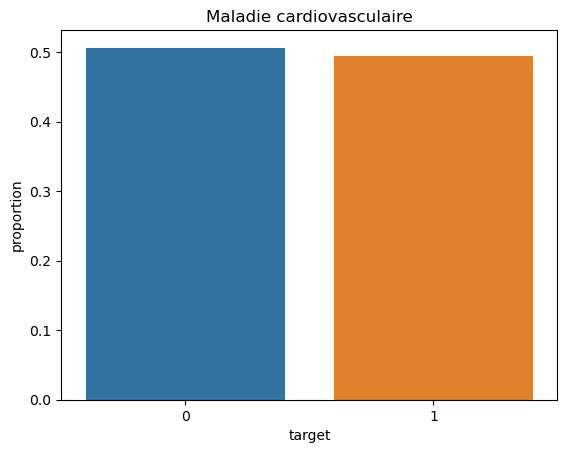

In [302]:
# visualisation
sns.countplot(x = 'target', data = data, hue = 'target', stat = "proportion",legend = False)
plt.title("Maladie cardiovasculaire")
plt.show()

Les deux classes sont équilibrées,il y'a donc presqu'autant de patients diagnostiqués d'une maladie cardiovasculaire et que ceux ne l'ayant pas été.

De plus, il ne sera donc pas utile de mettre en place des méthodes de ré-échantillonnage comme l'**Oversampling** qui sert à équilibrer les classes dans le but de réduire la tendance du modèle à mieux prédire la classe majoritaire.

## Les variables qualitatives

In [303]:
cat_var = data[["sexe", "cholesterol", "glucose", "fumeur", "alcool", "sport", "press_arterielle"]]
cat_var = cat_var.copy()

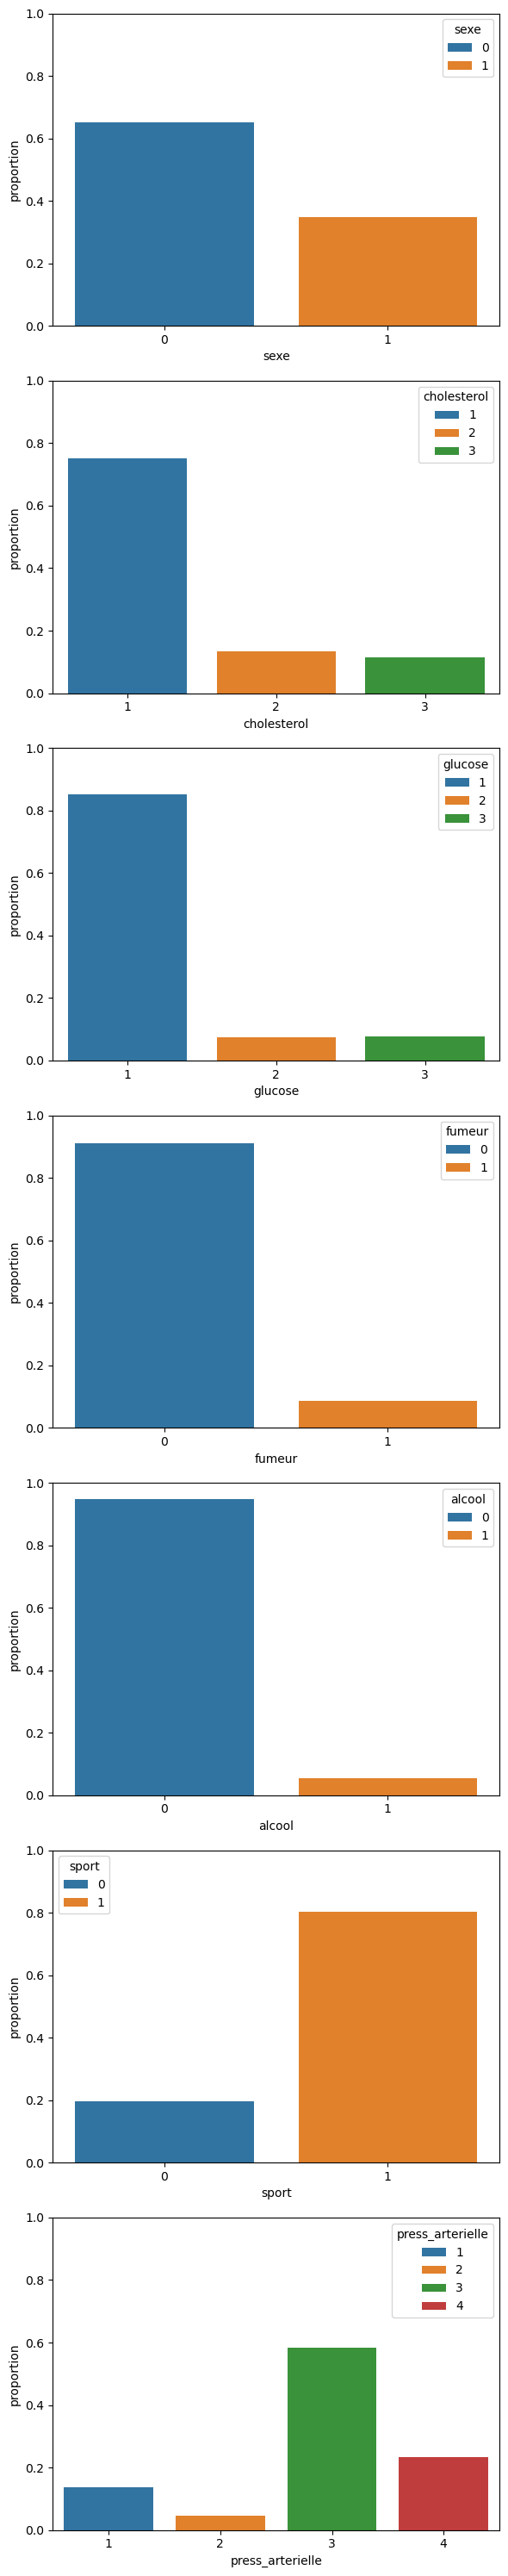

In [304]:
fig, axes = plt.subplots(cat_var.shape[1], 1, figsize = (6, 30))
i = 0
for var in cat_var.columns:
  sns.countplot(x = var, data = cat_var, hue = var, stat = "proportion", ax = axes[i])
  axes[i].set_ylim(0, 1.0)
  i = i + 1
plt.tight_layout()
plt.show()

On peut remarquer qu'au moins **2/3** des patients sont des **femmes**, et que la **grande majorité des patients** sont **non-fumeur**, **ne consomment pas d'alcool**, ont des **taux normaux** de **cholestérol**, de **glucose** et **pratique** une **activité pphysique** régulière.

Toutefois, **plus de la moitié** des patients sont en **stade 1 de l'hypertension** (pression artérielle).

## Les variables numériques (quantitatives)

In [305]:
num_var = data[["taille", "poids", "press_systolique", "press_diastolique", "age", "imc"]]
num_var = num_var.copy()

In [306]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sexe               68205 non-null  category
 1   taille             68205 non-null  int64   
 2   poids              68205 non-null  float64 
 3   press_systolique   68205 non-null  int64   
 4   press_diastolique  68205 non-null  int64   
 5   cholesterol        68205 non-null  category
 6   glucose            68205 non-null  category
 7   fumeur             68205 non-null  category
 8   alcool             68205 non-null  category
 9   sport              68205 non-null  category
 10  target             68205 non-null  category
 11  age                68205 non-null  int64   
 12  imc                68205 non-null  float64 
 13  press_arterielle   68205 non-null  category
dtypes: category(8), float64(2), int64(4)
memory usage: 3.6 MB


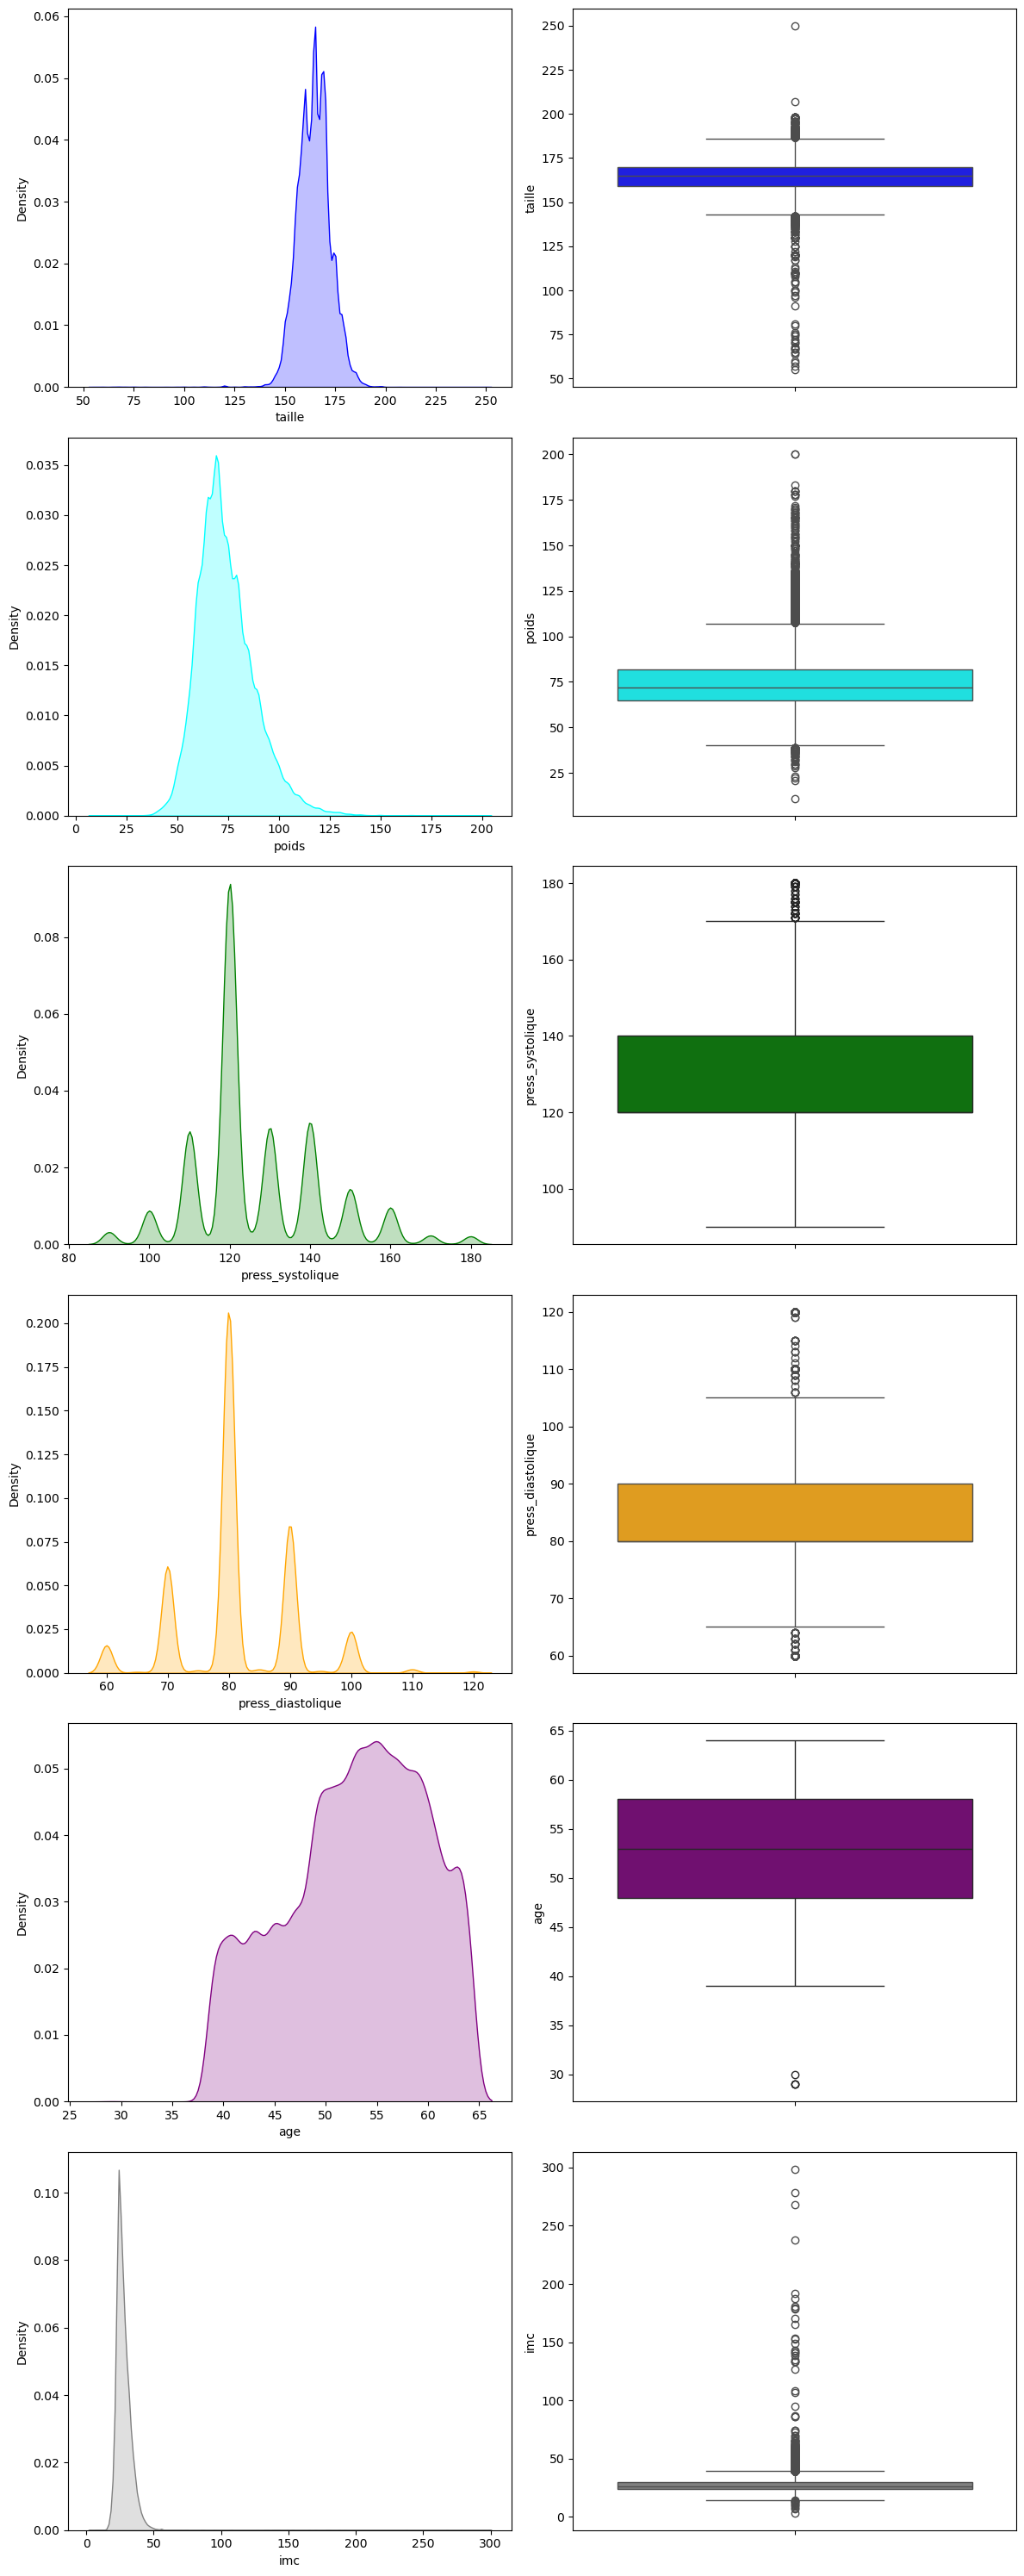

In [307]:
fig, axes = plt.subplots(num_var.shape[1], 2, figsize = (12, 30))
i = 0
colors = ["blue", "cyan", "green", "orange", "purple", "gray"]
for var in num_var.columns:
  sns.kdeplot(x = var, data = num_var, fill = True, color = colors[i], ax = axes[i, 0])
  sns.boxplot(y = var, data = num_var, color = colors[i], ax = axes[i, 1])
  i = i + 1
plt.tight_layout()
plt.show()

In [308]:
num_var.describe()

,taille,poids,press_systolique,press_diastolique,age,imc
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000
mean,164.372861,74.100688,126.434924,81.263925,52.823635,27.510513
std,8.176756,14.288862,15.961685,9.143985,6.769909,6.026497
min,55.000000,11.000000,90.000000,60.000000,29.000000,3.471784
25%,159.000000,65.000000,120.000000,80.000000,48.000000,23.875115
50%,165.000000,72.000000,120.000000,80.000000,53.000000,26.346494
75%,170.000000,82.000000,140.000000,90.000000,58.000000,30.116213
max,250.000000,200.000000,180.000000,120.000000,64.000000,298.666667


#### Interprétation :

- **Taille** : distribution centrée autour de 165 cm, mais présence de valeurs extrêmes (`min = 55 cm`, `max = 250 cm`) peu plausibles pour des adultes. Probables erreurs de saisie à filtrer ou corriger.

- **Poids** : valeurs majoritairement cohérentes, **mais `11 kg` en minimum est biologiquement invraisemblable*** pour un adulte. À exclure ou corriger.

- **Pression systolique** : distribution dans une plage réaliste (90 à 180 mmHg), bien que probablement asymétrique vers la droite. Valeurs élevées possibles en cas d’hypertension avancée, mais pas aberrantes.

- **Pression diastolique** : intervalle de 60 à 120 mmHg, plausible cliniquement. Peut indiquer des cas d’hypertension modérée à sévère, sans signe évident d’erreur de saisie.

- **Âge** : distribution homogène entre 29 et 64 ans, conforme à une population adulte en suivi cardiovasculaire. Aucune valeur aberrante détectée.

- **IMC** : distribution typique centrée autour de 27, mais présence d’un extrême (`IMC = 298`) totalement irréaliste. Erreur manifeste, souvent liée à un mauvais calcul (taille en cm au lieu de m par exemple). On va donc recalculer l'**IMC** puisque l'on dispose des variables poids et taille que l'on ramènera aux échelles convenables (mètre et kilogramme).

## Gestion des valeurs aberrantes

#### 1. La taille :
pour un adulte les valeurs en dessous d'1m50 sont très peu probable, ainsi la méthode choisi sera de remplacer la taille des tous les patients en dessous du seuil 1m59 par la valeur du premier quartile (qui est 1m59 soit 159 cm) et tous individus ayant plus de 2m par la valeur 2m

In [309]:
num_var.loc[data["taille"] < 159, "taille"] = 159
num_var.loc[data["taille"] > 200, "taille"] = 200

In [310]:
num_var["taille"].describe()

count    68205.000000
mean       165.534301
std          6.343489
min        159.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        200.000000
Name: taille, dtype: float64

#### 2. Le poids des patients:
Un poids en dessous de **50 kg** pour un adulte d'en **moyenne 1m59 à 1m60** donc un indice de masse corporelle **(IMC)** de **18.3** qui est une insuffisance pondérale très légère (d'après l'OMS) puisque la corpulance normale est entre 18.5 et 24.9 d'IMC

In [311]:
# statistiques des patients de moins de 50 kg
num_var[num_var["poids"] < 50].describe()

,taille,poids,press_systolique,press_diastolique,age,imc
count,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000
mean,160.142558,45.360220,116.128931,75.485325,51.681342,19.008593
std,2.819251,3.842007,16.769881,9.825460,7.359822,2.116235
min,159.000000,11.000000,90.000000,60.000000,39.000000,3.471784
25%,159.000000,44.000000,100.750000,70.000000,45.000000,17.799929
50%,159.000000,46.000000,120.000000,80.000000,52.000000,19.044321
75%,159.000000,48.000000,120.000000,80.000000,58.000000,20.395421
max,178.000000,49.000000,180.000000,120.000000,64.000000,31.360000


In [312]:
# remplacement des valeurs de poids en dessous de 50kg par un poids de 50kg
num_var.loc[num_var["poids"] < 50, "poids"] = 50

In [313]:
# les patients de plus de 170 kg
num_var[num_var["poids"] > 170].describe()

,taille,poids,press_systolique,press_diastolique,age,imc
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,176.384615,181.307692,130.000000,83.076923,48.769231,74.705995
std,10.642200,8.910524,11.547005,8.548504,6.098550,61.343997
min,159.000000,171.000000,110.000000,70.000000,41.000000,46.855477
25%,169.000000,178.000000,120.000000,80.000000,45.000000,56.481481
50%,177.000000,180.000000,130.000000,80.000000,47.000000,58.109504
75%,180.000000,180.000000,140.000000,90.000000,52.000000,61.728395
max,196.000000,200.000000,150.000000,100.000000,59.000000,278.125000


Les patients de plus de 170 kg mesurent **en moyenne plus 1m76**, alors les valeurs de poids > 170 kg sont cohérentes sur le plan clinique, même si elles restent extrêmes. On va donc conserver ces valeurs de poids

#### 3. Âge, pressions Systolique et Diastolique:

In [314]:
num_var[["age", "press_systolique", "press_diastolique"]].describe()

,age,press_systolique,press_diastolique
count,68205.000000,68205.000000,68205.000000
mean,52.823635,126.434924,81.263925
std,6.769909,15.961685,9.143985
min,29.000000,90.000000,60.000000
25%,48.000000,120.000000,80.000000
50%,53.000000,120.000000,80.000000
75%,58.000000,140.000000,90.000000
max,64.000000,180.000000,120.000000


L'**âge** et les **pressions artérielles systolique et diastolique** prennent des valeurs plausibles sur le plan clinique.

**Analyse des pressions artérielles** :

Voici une correspondance claire entre tes **modalités ordinales (1 à 4)** et les seuils de **pression artérielle systolique**, selon les recommandations internationales (*ACC/AHA 2017*, *OMS*) :

| **Modalité** | **Catégorie clinique**        | **Pression systolique (mmHg)** |
|--------------|-------------------------------|-------------------------------|
| 1            | Normale                       | < 120                         |
| 2            | Élevée (*Elevated*)           | 120 – 129                     |
| 3            | Hypertension Stade 1          | 130 – 139                     |
| 4            | Hypertension Stade 2          | ≥ 140                         |


**Avec nos données** :
1. Pression systolique (max : 180 mmHg, min : 90 mmHg)
  - La moyenne de 126 mmHg se situe juste au-dessus de la normale (< 120 mmHg), ce qui est logique dans un groupe des patients à risque cardiovasculaire.
  - 25% des patients dépassent déjà 140 mmHg, seuil de l’hypertension stade 2.
  - La valeur maximale de 180 mmHg représente une hypertension sévère, mais reste plausible sur le plan clinique.
---

les seuils de **pression artérielle diastolique**:

| **Modalité** | **Catégorie clinique**        | **Pression diastolique (mmHg)** |
|--------------|-------------------------------|-------------------------------|
| 1            | Normale                       | < 80                         |
| 2            | Élevée (*Elevated*)           | 80 – 89                     |
| 3            | Hypertension Stade 1          | 90 – 99                     |
| 4            | Hypertension Stade 2          | ≥ 100                       |


**Interprétation des données**:

2. Pression diastolique :
  - Min : 60 mmHg
  - Max : 120 mmHg
  - Moyenne : 81 mmHg

Ces valeurs couvrent une plage cliniquement plausible, bien que la distribution semble asymétrique vers les valeurs élevées.
  - 60 mmHg correspond à une pression diastolique basse mais encore dans les limites normales.
  - 80 mmHg (médiane) est le seuil supérieur de la normalité selon les recommandations internationales.
  - ≥ 90 mmHg indique une hypertension diastolique (stade 1), et 120 mmHg peut signaler une hypertension sévère, voire une urgence hypertensive — rare mais possible dans une population à risque.


#### 4. l'Indice de Masse Corporelle (IMC):
On va recalculer cette variable à l'aide de la formule suivante:
$
\text{IMC} = \frac{\text{Poids (kg)}}{[\text{Taille (m)}]^2}
$

In [315]:
num_var["imc"] = num_var["poids"] / ((num_var["taille"] / 100)**2)

In [316]:
num_var["imc"].describe()

count    68205.000000
mean        27.065193
std          4.985268
min         14.577259
25%         23.711845
50%         26.026175
75%         29.687500
max         70.408607
Name: imc, dtype: float64

📊 Classification de l’IMC (kg/m²)

| **Catégorie**                      | **Valeur de l’IMC**   |
|------------------------------------|------------------------|
| Insuffisance pondérale sévère      | < 16,5                 |
| Insuffisance pondérale modérée     | 16,0 – 16,9            |
| Insuffisance pondérale légère      | 17,0 – 18,49           |
| Corpulence normale                 | 18,5 – 24,9            |
| Surpoids                           | 25,0 – 29,9            |
| Obésité modérée (Classe I)         | 30,0 – 34,9            |
| Obésité sévère (Classe II)         | 35,0 – 39,9            |
| Obésité morbide (Classe III)       | ≥ 40,0                 |

- Moyenne : 27,07 → Cela confirme une population majoritairement en surpoids léger, selon la classification de l’OMS.
- Écart-type : 4,99 → Une variabilité modérée, ce qui reflète une diversité de corpulences sans extrêmes massifs.
- Médiane : 26,03 → Très proche de la moyenne, ce qui indique une distribution relativement symétrique.
- 1er quartile (Q1) : 23,71 / 3e quartile (Q3) : 29,69 → 50 % des patients ont un IMC dans la plage poids normal ↔ surpoids avancé, soit une corpulence globalement modérée.
- Minimum : 14,58 → Cela signale des cas d’insuffisance pondérale sévère, rares mais biologiquement plausibles.
- Maximum : 70,41 → IMC très élevé, correspondant à de l’obésité morbide classe III ; plausible sur le plan médical, mais mérite vérification du calcul chez les individus concernés.

In [317]:
# statistiques des individus avec un IMC >= 40 (obésité morbide)
num_var[num_var["imc"] >= 40].describe()

,taille,poids,press_systolique,press_diastolique,age,imc
count,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000
mean,163.276744,118.176589,137.201550,86.465891,53.293798,44.274341
std,5.591901,14.776079,17.895516,10.049490,6.611440,4.523722
min,159.000000,102.000000,90.000000,60.000000,39.000000,40.009145
25%,159.000000,108.000000,120.000000,80.000000,49.000000,41.270077
50%,161.000000,114.000000,140.000000,90.000000,54.000000,42.767884
75%,165.000000,125.000000,150.000000,90.000000,59.000000,45.720146
max,196.000000,200.000000,180.000000,120.000000,64.000000,70.408607


Les personnes en obésité morbide ont en moyenne une taille 1m60 et un poids moyen de 110kg. les données sont donc cohérentes.

#### visualisation des variables numériques modifiées

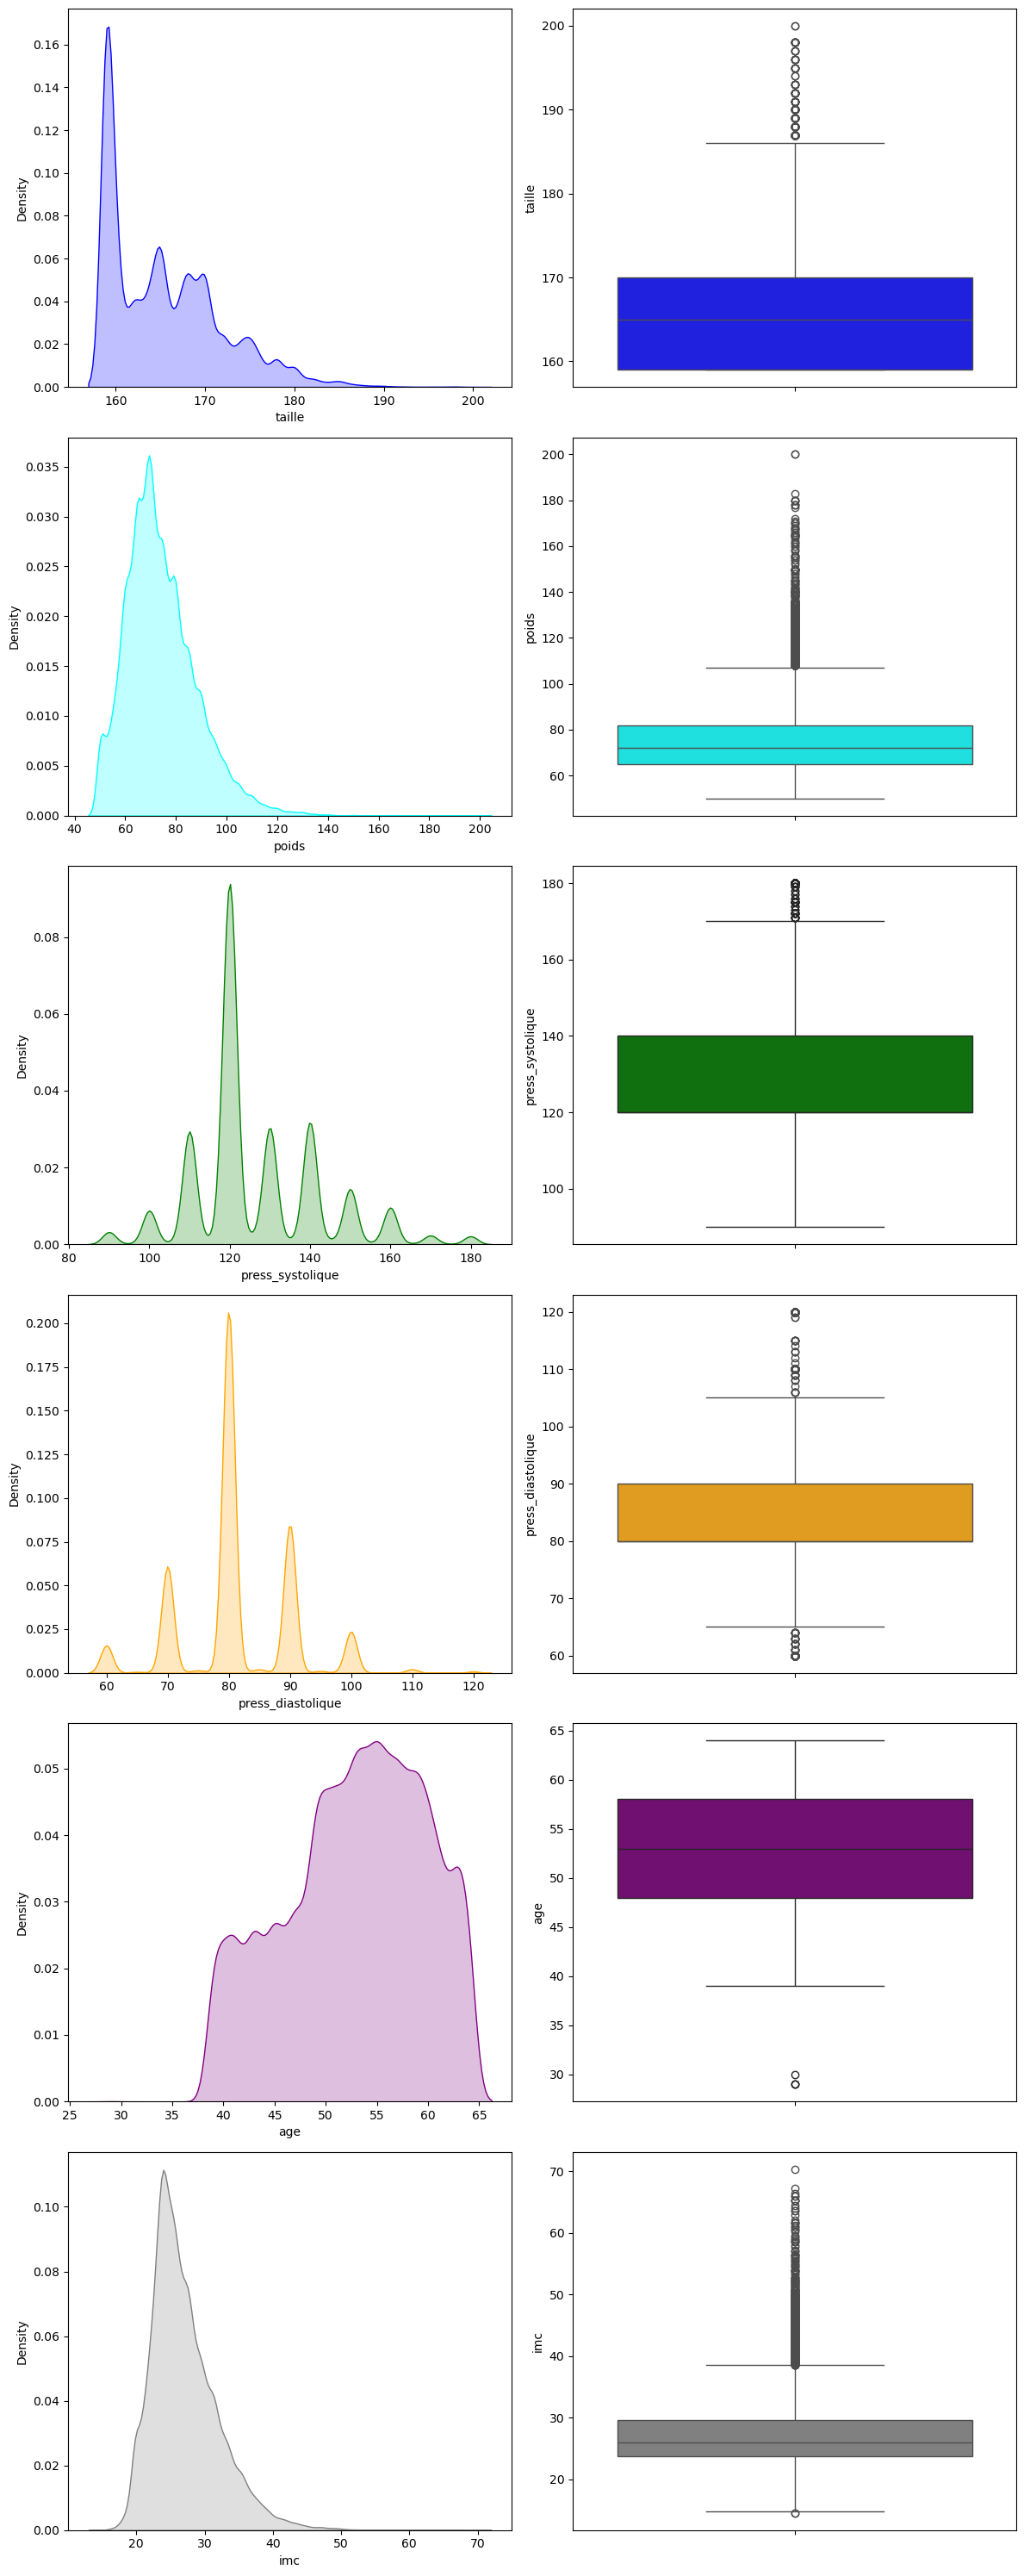

In [318]:
fig, axes = plt.subplots(num_var.shape[1], 2, figsize = (12, 30))
i = 0
colors = ["blue", "cyan", "green", "orange", "purple", "gray"]
for var in num_var.columns:
  sns.kdeplot(x = var, data = num_var, fill = True, color = colors[i], ax = axes[i, 0])
  sns.boxplot(y = var, data = num_var, color = colors[i], ax = axes[i, 1])
  i = i + 1
plt.tight_layout()
plt.show()

# Analyse bivariée

## 1. Variables catégorielles avec la cible

In [319]:
cat_var["target"] = data["target"]

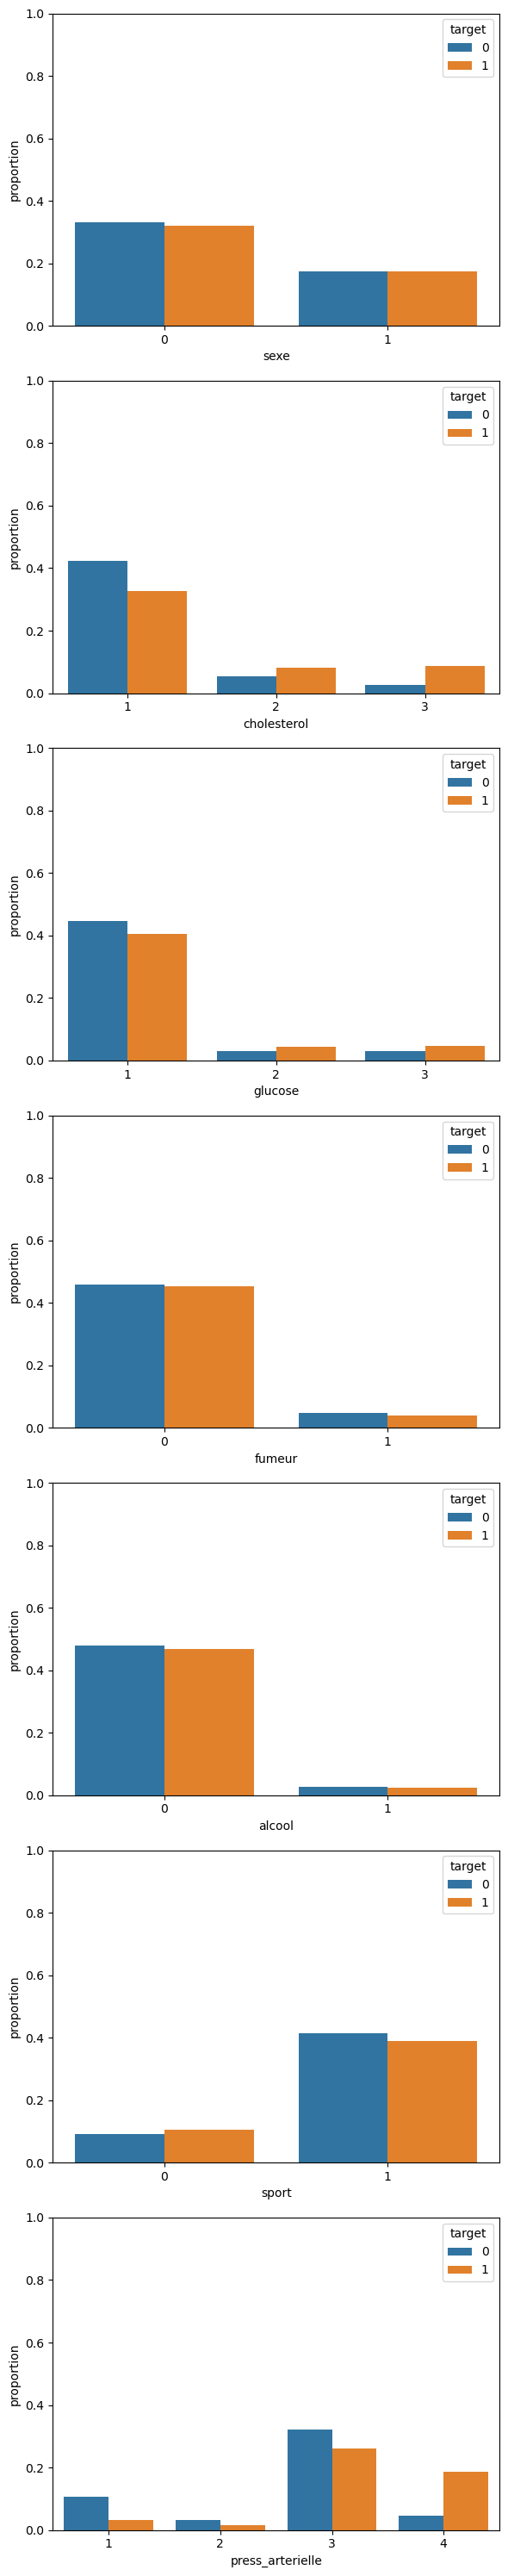

In [320]:
fig, axes = plt.subplots(cat_var.shape[1] - 1, 1, figsize = (6, 30))
i = 0
var_list = list(cat_var.columns)
var_list.remove("target")
for var in var_list:
  sns.countplot(x = var, data = cat_var, hue = "target", stat = "proportion", ax = axes[i])
  axes[i].set_ylim(0, 1.0)
  i = i + 1
plt.tight_layout()
plt.show()

Visuellement on peut observer **l'influence ou la liaison des variables explicatives sur la  cible** par le déséquilibre des personnes malades au sein de chaque classe de la variable catégorielle explicative d'intérêt.

Le cas des malades qui sont **majoritairement non-fumeur** comparé aux **fumeurs** ou même qu'il y'a plus **des maladies cardiovasculaires** chez les patients ayant un **taux normal de glucose** (modalité 1).

Toutefois, un **graphique bivarié** peut refléter **un déséquilibre** qui vient soit de la **variable cible** (target), soit de la **variable explicative**, **soit des deux**.

En effet, on a vu précédemment lors de l'analyse univariée des variables qualitatives que **certaines variables avaient des classes fortement déséquilibrées**, notamment les non-fumeurs qui constitués la quasi-totalité des patients ou même que les patients au taux de glucose sanguin normal étaient largement majoritaires.

Ainsi, **il se pourrait que le déséquilibre** des distributions de la variable cible au sein des classes de la variable **fumeur** ou même **glucose** **provient du déséquilibre déjà existant au sein des modalités de ces variables**.

Finalement, nous mettrons en place des **tests de Chi-deux** pour voir si les variables sont indépendantes au sens statistiques.


In [321]:
import scipy.stats as stats

In [322]:
def test_chi2(variables):
    result = {}
    for var1 in variables.columns:
        result[var1] = []
        for var2 in variables.columns:
          # Éviter de tester la variable avec elle-même
            if var1 != var2:
                table_contingence = pd.crosstab(variables[var1], variables[var2])
                _, p_value, _, _ = stats.chi2_contingency(table_contingence)
                result[var1].append(round(p_value, 2))  # Arrondi à 2 décimales
            else:
                result[var1].append(None)
    # Transformer en DataFrame
    corr_df = pd.DataFrame(result, index=variables.columns)
    # true si il y'a association : p_valeur < 0.05(dépendance car on rejette H0)
    corr_df = corr_df < 0.05
    return corr_df

In [323]:
test_chi2(cat_var)

,sexe,cholesterol,glucose,fumeur,alcool,sport,press_arterielle,target
sexe,False,True,True,True,True,False,True,False
cholesterol,True,False,True,True,True,True,True,True
glucose,True,True,False,True,True,True,True,True
fumeur,True,True,True,False,True,True,True,True
alcool,True,True,True,True,False,True,True,True
sport,False,True,True,True,True,False,True,True
press_arterielle,True,True,True,True,True,True,False,True
target,False,True,True,True,True,True,True,False


Hormis la variable sexe,  on voit que les liaisons deux à deux entre la variable cible (target) et toutes les variables explicatives sont statistiquement significatives, comme l'inpression visuelle.

Il est aussi observable que les variables **cholesterol**, **glucose** et **fumeur** sont significativement liées. Nous allons évaluer l'intensité de ce lien avec le **V de Cramer** qui est une version du coéfficient de corrélation mais cette fois-ci pour le cas de deux varaiables qualitatives.

In [324]:
def cramers_v(variables):
    result = {}
    for var1 in variables.columns:
        result[var1] = []
        for var2 in variables.columns:
            if var1 != var2:
                # Table de contingence
                table_contingence = pd.crosstab(variables[var1], variables[var2])
                chi2, _, _, _ = stats.chi2_contingency(table_contingence)
                # Calcul de V de Cramér
                n = table_contingence.sum().sum()
                # min(nb_lignes, nb_colonnes) - 1
                k = min(table_contingence.shape) - 1
                v_cramer = np.sqrt(chi2 / (n * k))
                result[var1].append(round(v_cramer, 2))
            else:
              # Valeur None pour éviter les auto-tests
                result[var1].append(None)
    # Transformer en DataFrame
    cramers_df = pd.DataFrame(result, index=variables.columns)
    return cramers_df

In [325]:
df_assoc = cramers_v(cat_var)
df_assoc

,sexe,cholesterol,glucose,fumeur,alcool,sport,press_arterielle,target
sexe,NaN,0.04,0.02,0.34,0.17,0.01,0.08,0.01
cholesterol,0.04,NaN,0.39,0.02,0.04,0.01,0.12,0.22
glucose,0.02,0.39,NaN,0.02,0.03,0.01,0.06,0.09
fumeur,0.34,0.02,0.02,NaN,0.34,0.02,0.02,0.02
alcool,0.17,0.04,0.03,0.34,NaN,0.02,0.03,0.01
sport,0.01,0.01,0.01,0.02,0.02,NaN,0.02,0.04
press_arterielle,0.08,0.12,0.06,0.02,0.03,0.02,NaN,0.37
target,0.01,0.22,0.09,0.02,0.01,0.04,0.37,NaN


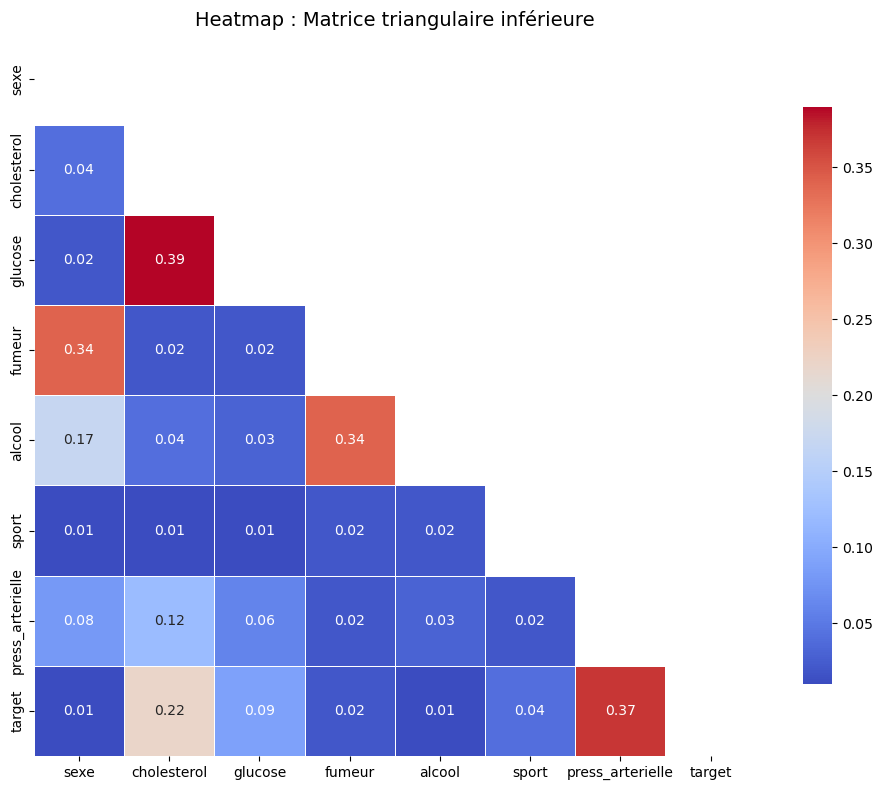

In [326]:
# Création du masque de la partie supérieure
mask = np.triu(np.ones_like(df_assoc, dtype=bool))

# Création de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_assoc,
            mask=mask,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.8})

plt.title("Heatmap : Matrice triangulaire inférieure", fontsize=14)
plt.tight_layout()
plt.show()

**Échelle d’interprétation du V de Cramér**

| **Valeur de V**       | **Force de l’association**         |
|------------------------|------------------------------------|
| 0.00 – 0.10            | Nulle à très faible                |
| 0.10 – 0.20            | Faible                             |
| 0.20 – 0.40            | Modérée                            |
| 0.40 – 0.60            | Forte                              |
| 0.60 – 0.80            | Très forte                         |
| 0.80 – 1.00            | Quasi-parfaite ou redondante       |

On peut voir une **relation modéré voir presque forte** entre la variable cible et **la pression artérielle** du patient, et une **relation modérée** entre la cible et le **taux de cholestérol** dans le sang.

On peut également voir les **relations fortes** entre le **taux de glucose et le taux de cholestérol**; les patients **fumeurs** et ceyx qui **consomment de l'alcool** et entre les variables **fumeur et sex**.

A ce stade il serait prudent de conserver toutes les variables.

## 2. Variables numériques avec la cible

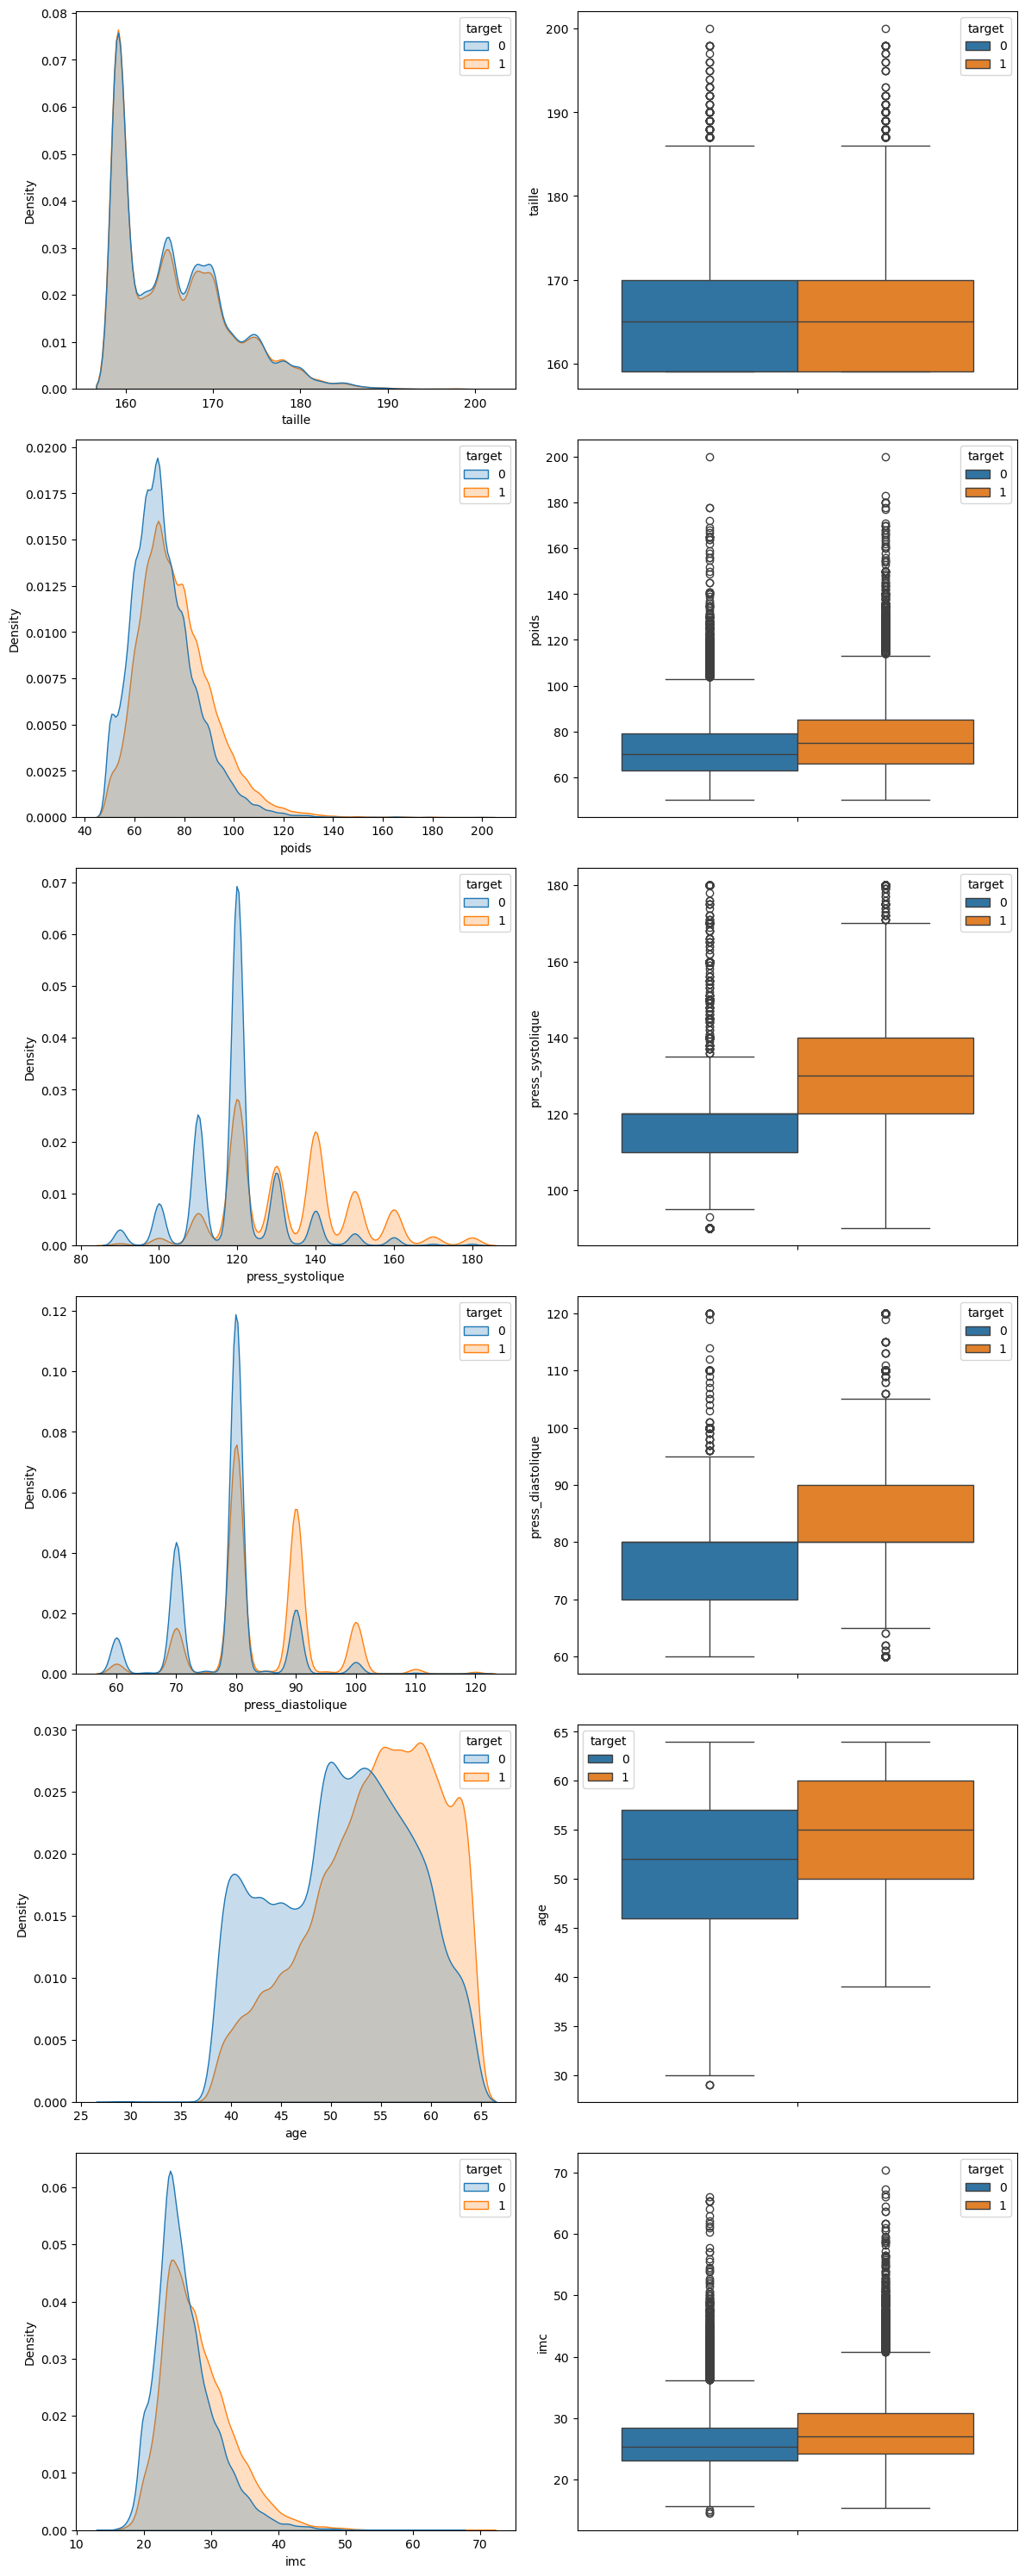

In [327]:
fig, axes = plt.subplots(num_var.shape[1], 2, figsize = (12, 30))
i = 0
var_list = list(num_var.columns)
num_var["target"] = data["target"]
for var in var_list:
  sns.kdeplot(x = var, data = num_var, fill = True, hue = "target", ax = axes[i, 0])
  sns.boxplot(y = var, data = num_var, hue = "target", ax = axes[i, 1])
  i = i + 1
plt.tight_layout()
plt.show()

On peut voir que les distributions au de la modalité malade (1) et pas malade (0) sont presque identiques, ce qui suggère une liaison très faible ou inexistante, entre la ciblent et certaines variables telles que : **imc**, **taille**, **poids**.

Les pressions artérielle, systolique et diastolique semblent être liées à la vriable cible. Ainsi que l'âge.

Les distributions des variables numériques au sein de chaque modalité de la variable cible ne semblent pas gaussiennes. Par conséquent les tests **t de Student** ou même l'**ANOVA** n'est pas approprié.

Il convient donc l'évaluer l'existance ou non d'un lien significatif entre les variables numériques et la cible à travers le test de **Kruskal-Wallis**

In [328]:
from scipy.stats import kruskal

In [329]:
def test_kruskal(variables, categorie):
    resultat = {"stat": [], "p-value": [], "Association with target": []}
    var_names = variables.columns

    for var in var_names:
        # Création des groupes en fonction de la variable catégorielle
        groupes = [
            variables[categorie == cat][var].dropna()
            for cat in categorie.unique()
        ]

        # Test de Kruskal-Wallis
        stat, p = kruskal(*groupes)
        resultat["stat"].append(stat)
        resultat["p-value"].append(p)
        resultat["Association with target"].append(p < 0.05)

    return pd.DataFrame(resultat, index=var_names)

In [330]:
num_var = num_var.drop("target", axis = 1)

Si la **p-valeur** du test de Kruskal-Wallis est **inférieure à 0.05**, cela indique le **rejet de l'hypothèse nulle**, qui stipule que les distributions des groupes sont identiques. **Cela signifie qu'il existe une différence significative entre au moins deux groupes**, ou encore que la variable numérique d'intérêt et la variable cible (qualitative) sont liées.

In [331]:
test_kruskal(num_var, data["target"])

,stat,p-value,Association with target
taille,7.731862,0.005425,True
poids,2180.507985,0.000000,True
press_systolique,13826.404808,0.000000,True
press_diastolique,8612.508691,0.000000,True
age,3822.659087,0.000000,True
imc,2554.758315,0.000000,True


**Toutes les variables numériques** semblent avoir un **lien statistiquement significatif** **avec la variable cible**, en particulier la **taille** et le **poids** où les distributions des patients malades et non-malade paraissaient visuellement assez proches.

## Variables numériques avec le **logit** de la variable cible:
Vérification de l'hypothèse de la relation linéiare entre les variables linéaire et le **logit** de la variable cible.

In [332]:
def plot_logit(num_df, target_df, n_bins=10):
    target_col = target_df.columns[0]
    full_df = num_df.copy()
    full_df[target_col] = target_df[target_col].astype(int)

    num_vars = num_df.columns
    n_rows = len(num_vars)

    plt.figure(figsize=(6, 4 * n_rows))

    for idx, var in enumerate(num_vars, start=1):
        # intervalle de la variable
        full_df[f"{var}_bin"] = pd.cut(full_df[var], bins=n_bins)

        # Probabilité empirique par intervalle
        grouped = full_df.groupby(f"{var}_bin")[target_col].mean().reset_index()
        grouped.columns = [f"{var}_bin", "prob"]

        # Centre des intervalles
        grouped["center"] = full_df.groupby(f"{var}_bin")[var].mean().reset_index(drop=True)

        # Calcul du logit
        grouped["logit"] = np.log(grouped["prob"] / (1 - grouped["prob"]))
        grouped = grouped.dropna(subset=["center", "logit"])
        grouped = grouped[np.isfinite(grouped["logit"])]

        # Régression linéaire pour la tendance
        coeffs = np.polyfit(grouped["center"], grouped["logit"], deg=1)
        line = np.poly1d(coeffs)

        # Affichage
        plt.subplot(n_rows, 1, idx)
        plt.scatter(grouped["center"], grouped["logit"], label="Logits observés")
        plt.plot(grouped["center"], line(grouped["center"]), color="red", label="Droite de régression")
        plt.title(f"Relation logit – {var}")
        plt.xlabel(var)
        plt.ylabel("logit")
        plt.legend()

    plt.tight_layout()
    plt.show()

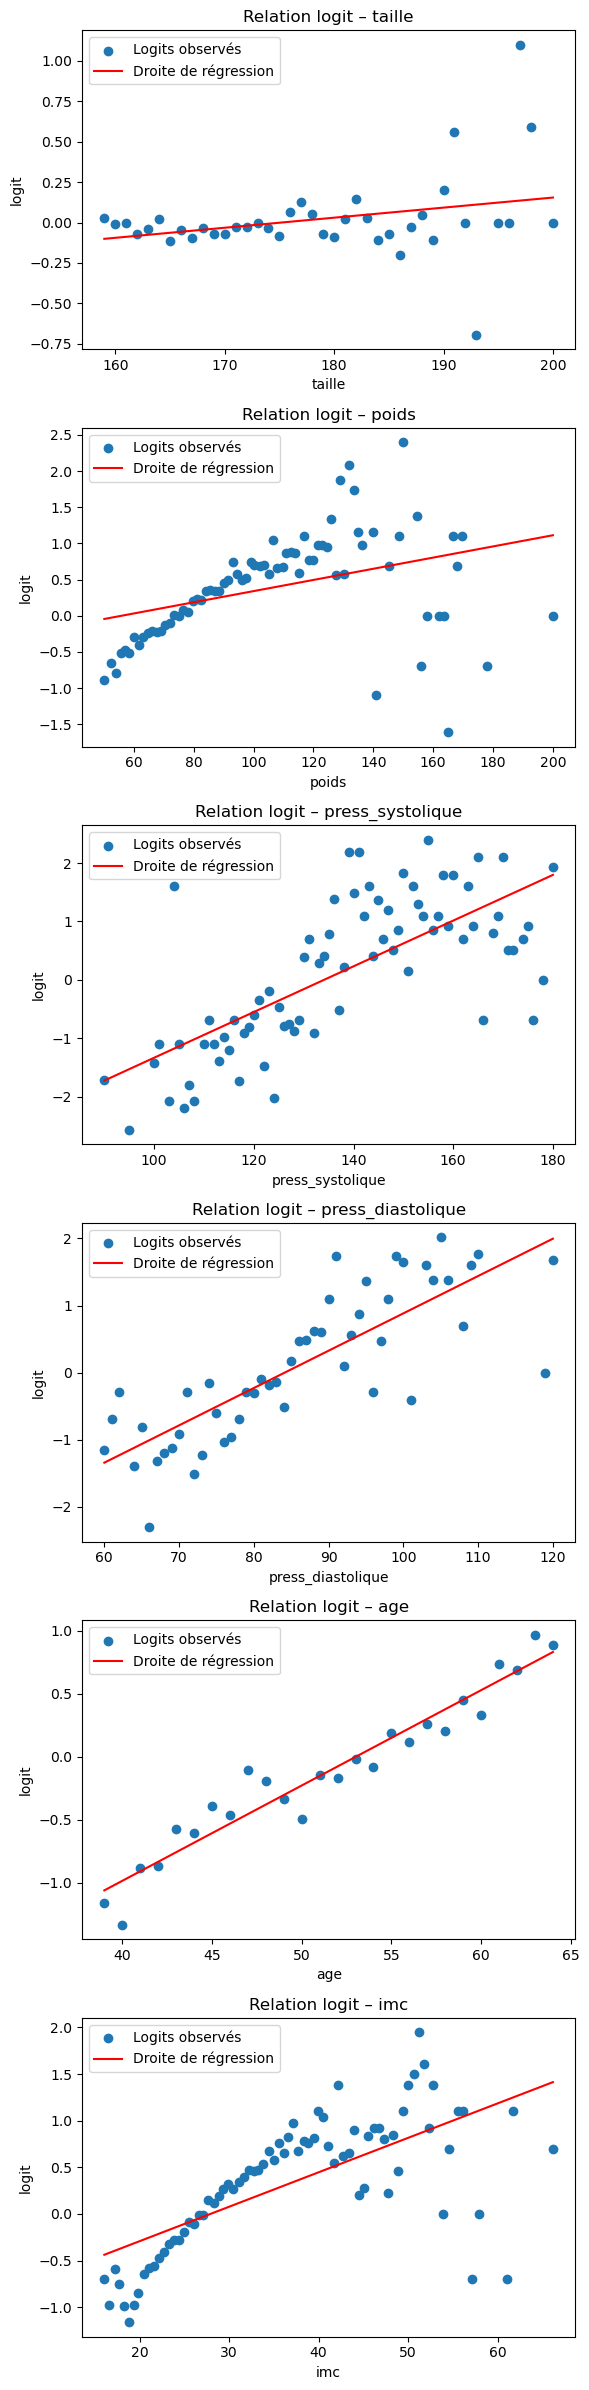

In [333]:
plot_logit(num_var, pd.DataFrame(data["target"]), 100)

Remarquons que les variables **age**, **taille** et **press_diastolique** semblent avoir une relation visuellement linéaire avec le **logit** de la variable cible.

Cependant, l'**imc** et le **poids** et la **pression systolique** ne semblent pas avoir cette relation linéaire.

Nous allons calculer les coéfficients de corrélation.

In [334]:
from scipy.stats import spearmanr, kendalltau

In [335]:
def logit_correlations(num_df, target_df, n_bins=100):
    target_col = target_df.columns[0]
    full_df = num_df.copy()
    full_df[target_col] = target_df[target_col].astype(int)

    results = []

    for var in num_df.columns:
        # Binning de la variable
        full_df[f"{var}_bin"] = pd.cut(full_df[var], bins=n_bins)

        # Moyenne de la cible par bin
        grouped = full_df.groupby(f"{var}_bin")[target_col].mean().reset_index()
        grouped.columns = [f"{var}_bin", "prob"]

        # Centre des intervalles pour X
        grouped["center"] = full_df.groupby(f"{var}_bin")[var].mean().reset_index(drop=True)

        # Calcul du logit
        grouped["logit"] = np.log(grouped["prob"] / (1 - grouped["prob"]))
        grouped = grouped.dropna(subset=["center", "logit"])
        grouped = grouped[np.isfinite(grouped["logit"])]

        if len(grouped) > 1:
            pearson_corr = grouped["center"].corr(grouped["logit"], method='pearson')
            spearman_corr = spearmanr(grouped["center"], grouped["logit"]).correlation
            kendall_corr = kendalltau(grouped["center"], grouped["logit"]).correlation
        else:
            pearson_corr = spearman_corr = kendall_corr = np.nan

        results.append({
            "Variable": var,
            "Pearson": pearson_corr,
            "Spearman": spearman_corr,
            "Kendall": kendall_corr
        })

    df_corr = pd.DataFrame(results).set_index("Variable")
    return df_corr

In [336]:
logit_correlations(num_var, pd.DataFrame(data["target"]), 100)

,Pearson,Spearman,Kendall
Variable,,,
taille,0.290181,0.260657,0.170326
poids,0.379071,0.524048,0.510499
press_systolique,0.711117,0.709922,0.528116
press_diastolique,0.811044,0.842368,0.669133
age,0.963963,0.974017,0.876923
imc,0.674831,0.707435,0.617391


Apès calcul:
- **age** et **press_diastolique**: très fortement corrélé avec le logit de la cible.
- **press_systolique** et **imc** fortement corrélés au logit
- **poids** corrélation modéré avec le logit de la variable cible et la **taille** est faiblement corrélée avec le logit de la cible.

## Variables numériques entre elles:
Indentification des variables fortement corrélées pour éviter la redondance et la multicolinéarité

In [337]:
num_var.head(1)

,taille,poids,press_systolique,press_diastolique,age,imc
0,168,62.0,110,80,50,21.96712


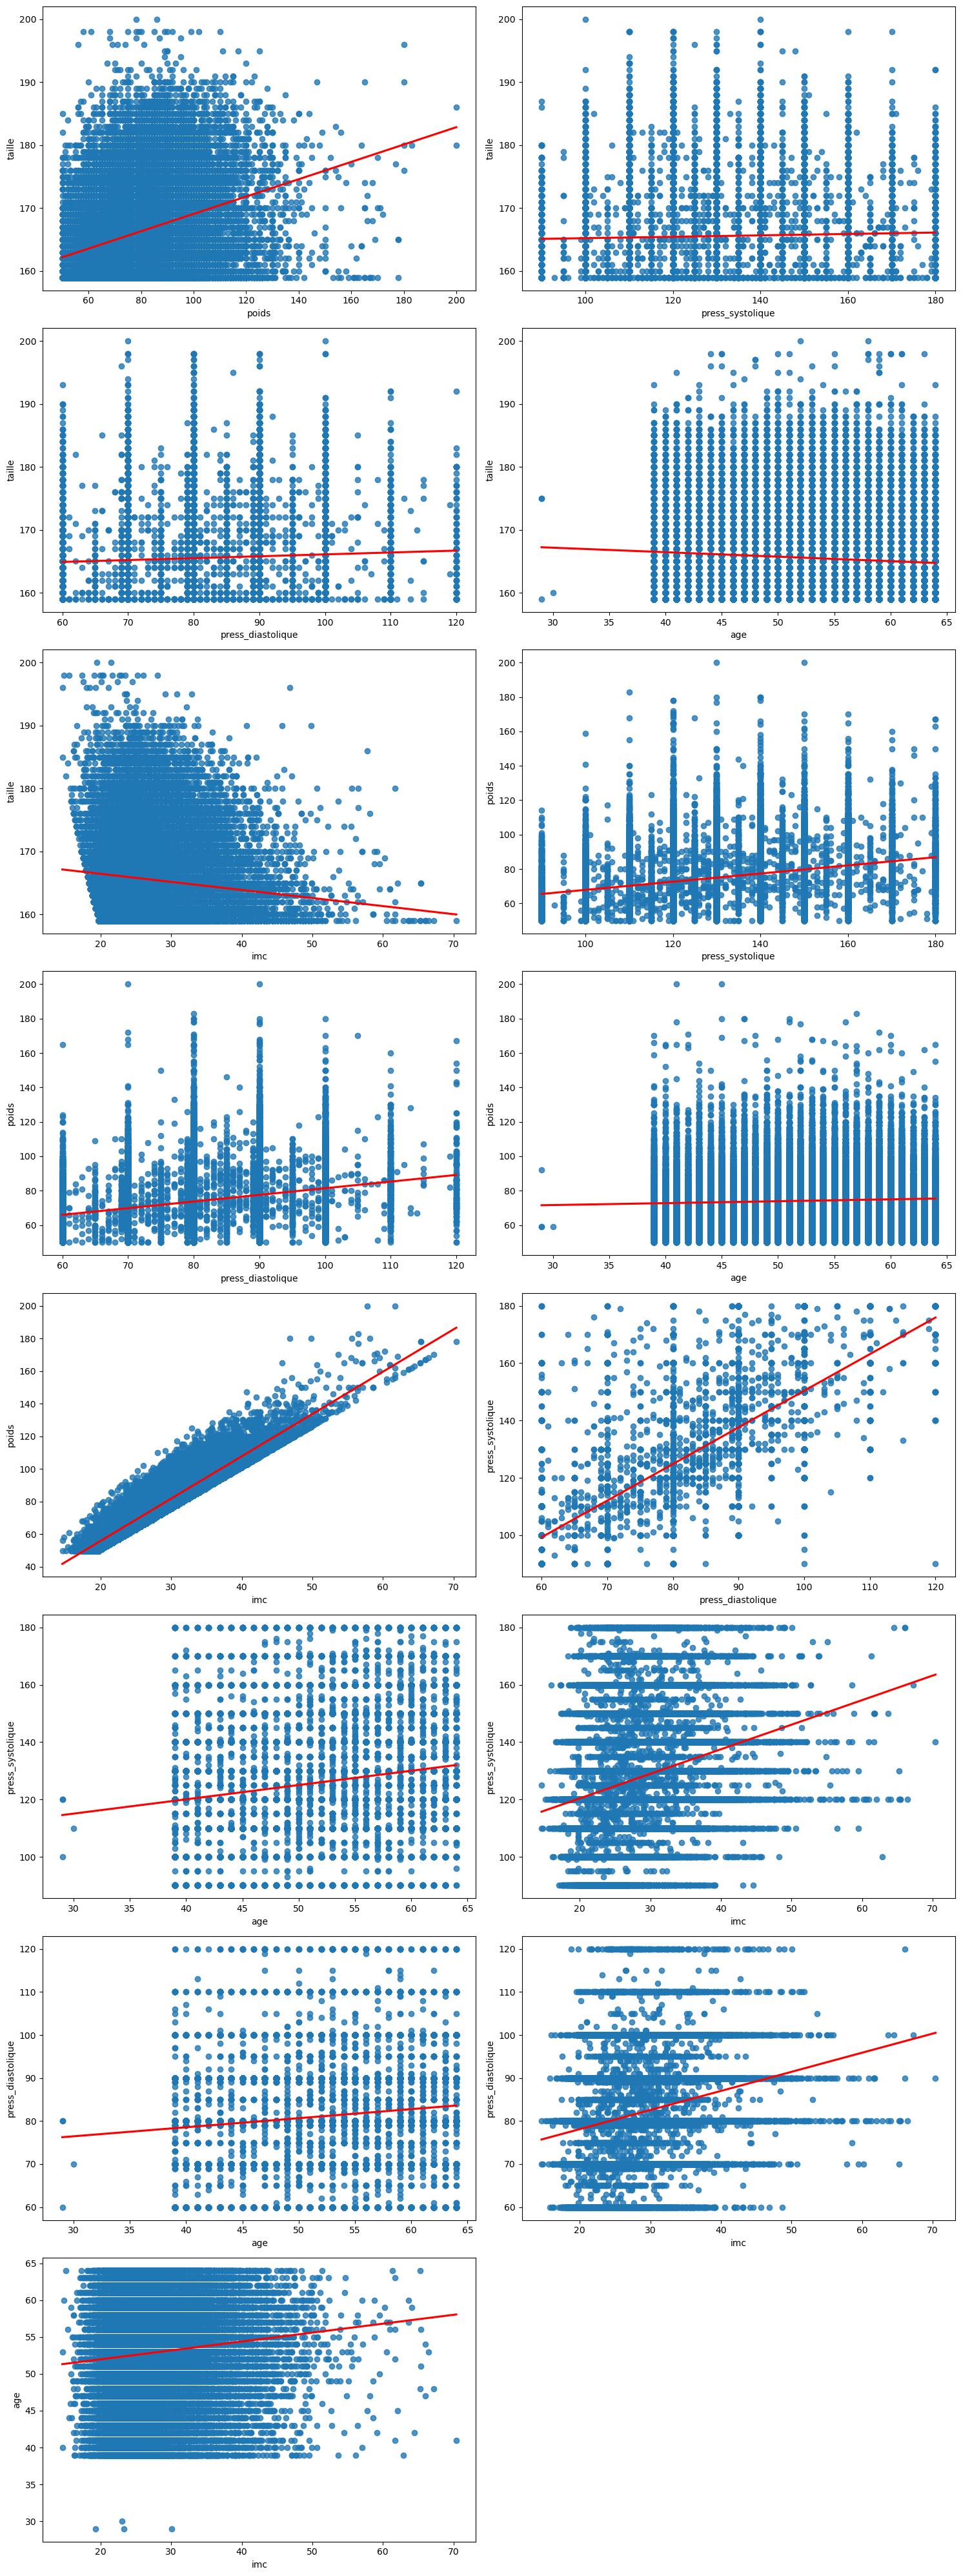

In [338]:
fig, axes = plt.subplots(8, 2, figsize = (15, 40))
# taille - poids
sns.regplot(y = num_var["taille"], x = num_var["poids"], line_kws={"color": "red"}, ci = None, ax = axes[0, 0])
# taille - pression systolique
sns.regplot(y = num_var["taille"], x = num_var["press_systolique"], line_kws={"color": "red"}, ci = None, ax = axes[0, 1])
# taille - pression diastolique
sns.regplot(y = num_var["taille"], x = num_var["press_diastolique"], line_kws={"color": "red"}, ci = None, ax = axes[1, 0])
# taille - age
sns.regplot(y = num_var["taille"], x = num_var["age"], line_kws={"color": "red"}, ci = None, ax = axes[1, 1])
# taille - imc
sns.regplot(y = num_var["taille"], x = num_var["imc"], line_kws={"color": "red"}, ci = None, ax = axes[2, 0])
# poids - pression systolique
sns.regplot(y = num_var["poids"], x = num_var["press_systolique"], line_kws={"color": "red"}, ci = None, ax = axes[2, 1])
# poids - pression diastolique
sns.regplot(y = num_var["poids"], x = num_var["press_diastolique"], line_kws={"color": "red"}, ci = None, ax = axes[3, 0])
# poids - age
sns.regplot(y = num_var["poids"], x = num_var["age"], line_kws={"color": "red"}, ci = None, ax = axes[3, 1])
# poids - imc
sns.regplot(y = num_var["poids"], x = num_var["imc"], line_kws={"color": "red"}, ci = None, ax = axes[4, 0])
# press_systolique - pression diastolique
sns.regplot(y = num_var["press_systolique"], x = num_var["press_diastolique"], line_kws={"color": "red"}, ci = None, ax = axes[4, 1])
# press_systolique - age
sns.regplot(y = num_var["press_systolique"], x = num_var["age"], line_kws={"color": "red"}, ci = None, ax = axes[5, 0])
# press_systolique - imc
sns.regplot(y = num_var["press_systolique"], x = num_var["imc"], line_kws={"color": "red"}, ci = None, ax = axes[5, 1])
# press_diastolique - age
sns.regplot(y = num_var["press_diastolique"], x = num_var["age"], line_kws={"color": "red"}, ci = None, ax = axes[6, 0])
# press_diastolique - imc
sns.regplot(y = num_var["press_diastolique"], x = num_var["imc"], line_kws={"color": "red"}, ci = None, ax = axes[6, 1])
# age - imc
sns.regplot(y = num_var["age"], x = num_var["imc"], line_kws={"color": "red"}, ci = None, ax = axes[7, 0])
axes[7, 1].axis("off")
plt.tight_layout()
plt.show()

Visuellement il n'y a que l'**imc** et le **poids** qui sont fortement corrélés, ce qui est cohérent du fait que l'**imc** est directement proportionnel au poids et inversément proportionnel au carré de la taille.

In [339]:
# correlation de Pearson
num_var.corr(method = "pearson")

,taille,poids,press_systolique,press_diastolique,age,imc
taille,1.000000,0.307517,0.028051,0.043271,-0.075924,-0.100612
poids,0.307517,1.000000,0.267566,0.249429,0.053111,0.912948
press_systolique,0.028051,0.267566,1.000000,0.731812,0.211314,0.267409
press_diastolique,0.043271,0.249429,0.731812,1.000000,0.155777,0.242091
age,-0.075924,0.053111,0.211314,0.155777,1.000000,0.088913
imc,-0.100612,0.912948,0.267409,0.242091,0.088913,1.000000


L'observation visuelle s'appuie par le coéfficient de corrélation de Pearson des variables **imc** et **poids** qui indique une forte realtion linéaire positive (0.91).

On peut aussi voir que les pressions artérielles **systolique** et **diastolique** sont forttement corrélées.

Toutefois, puisque les relations entre les autres variables ne sont pas linéaires on visualiser les heatmap de corrélation avec les coéfficients de Spearman (relation monotone).

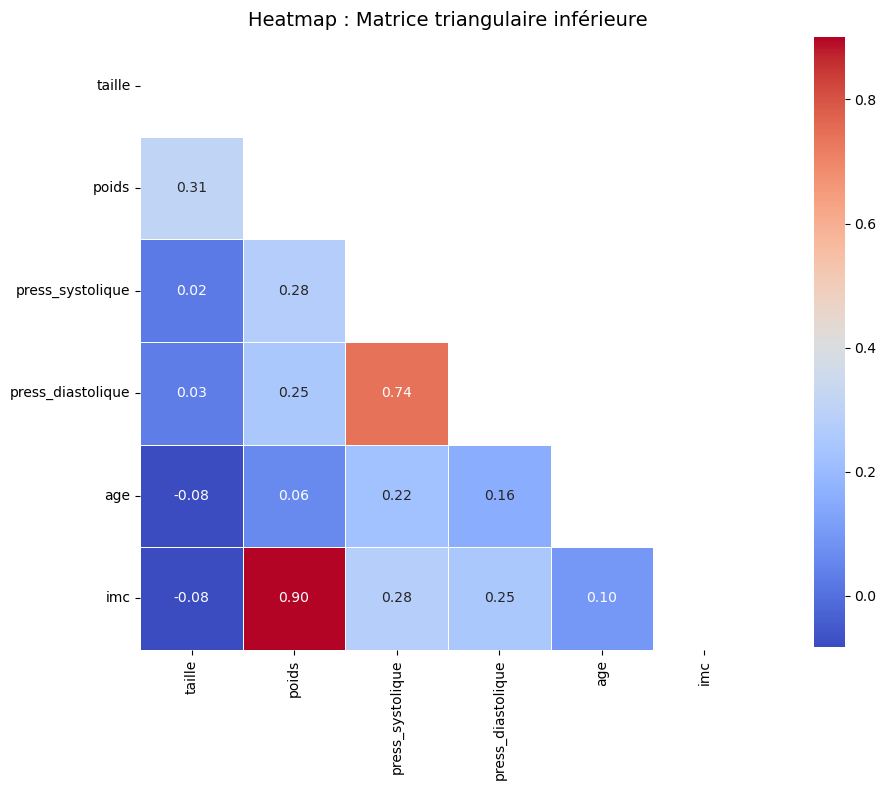

In [340]:
# Création du masque de la partie supérieure
mask = np.triu(np.ones_like(num_var.corr(method = "spearman"), dtype=bool))

# Création de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(num_var.corr(method = "spearman"),
            mask=mask,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.99})

plt.title("Heatmap : Matrice triangulaire inférieure", fontsize=14)
plt.tight_layout()
plt.show()

# Standardisation et sauvegarde des données nettoyées:

Etant donné que les variables numériques sont exprimées en des unités différentes (taille : cm, poids : kg, etc..), il convient de les standardiser afin de les ramener à des échelles comparables. Ces données nettoyées seront sauvegardées pour entrainer d'autres modèles de classification.

In [341]:
cat_var.head(2)

,sexe,cholesterol,glucose,fumeur,alcool,sport,press_arterielle,target
0,1,1,1,0,0,1,3,0
1,0,3,1,0,0,1,4,1


In [342]:
from sklearn.preprocessing import StandardScaler

In [343]:
# Standardisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_var)
num_var = pd.DataFrame(scaled_data, columns=num_var.columns)

In [344]:
data = pd.concat([num_var, cat_var], axis = 1)

In [345]:
data.head(3)

,taille,poids,press_systolique,press_diastolique,age,imc,sexe,cholesterol,glucose,fumeur,alcool,sport,press_arterielle,target
0,0.388700,-0.859102,-1.029656,-0.138226,-0.417089,-1.022635,1,1,1,0,0,1,3,0
1,-1.030088,0.765098,0.849859,0.955397,0.321479,1.315264,0,3,1,0,0,1,4,1
2,-0.084229,-0.717867,0.223354,-1.231849,-0.269376,-0.713585,0,3,1,0,0,0,3,1


In [346]:
data.to_csv("cardio_data_cleaned.csv", index = False)

# Séparation des données d'apprentissage et de test.

In [347]:
# variable cible
y = data["target"]
# variables explicatives
X = data.drop("target", axis = 1)

In [348]:
seed = 12

In [349]:
from sklearn.model_selection import train_test_split

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed, test_size = 0.2, stratify = y)

# Entraînement du modèle

In [351]:
from sklearn.linear_model import LogisticRegression

In [352]:
# instanciation du modèle
model = LogisticRegression(random_state = seed)

In [353]:
# entraînement du modèle
model.fit(X_train, y_train)

LogisticRegression(random_state=12)

# Prédiction sur les données de Test

In [354]:
y_pred = model.predict(X_test)

# interprétation des coéfficients

In [355]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay

In [356]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = "macro")
performances = pd.DataFrame({"Performances " : [acc, prec, rec, f1]}, index = ["accuracy", "precision", "recall", "f1_score"])

In [357]:
performances

,Performances
accuracy,0.726706
precision,0.755786
recall,0.659489
f1_score,0.725136


**Résultats**:

1. **accuracy** : est la proportion des prédictions correctes de la classe 0 et de la classe 1 sur l'ensemble des observations des données de test. ICi le modèle a prédit correctement 75% des patients.
---
2. **precision**: le ratio du nombre des prédictions correctes de la classe 1 par rapport au nombre des prédictions de la classes 1 du modèle (prédictions de la classe 1 correctes et incorrectes), soit 75%.
---
3. **recall**: est le rapport entre le nombre des patients malades correctement prédits et le nombre de tous les  patients malades des données de test. Ici le modèle a correctement prédit 65% des patients malades parmi tous les individus malades de l'ensemble de test.
---
4. **f1-score** : est une moyenne harmonique, une métrique d’évaluation qui combine deux mesures fondamentales : **la précision** (précision des prédictions positives) et le **rappel** (capacité à retrouver tous les vrais positifs).


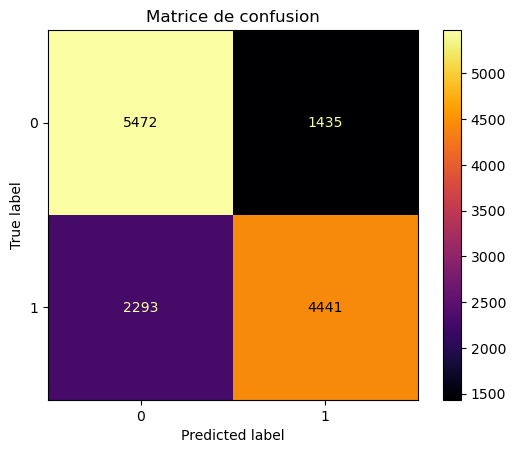

In [358]:
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred), display_labels= model.classes_)
disp.plot(cmap='inferno')
plt.title("Matrice de confusion")
plt.show()

La matrice de confusion permet d'afficher les informations sur le nombre des patients prédits comme malades (vrai et faux)  et ceux prédits comme n'étant pas malades (à raison ou à tord).

Le cas de la première ligne où sur un total de **6907** patients réellement pas malades, **5472** ont été prédites à raison comme pas malades (79%), tandis que 1435 ont été prédites, à tord, comme malades (20%). Ainsi, le modèle apprend assez bien la classe 0.

# Evaluation des performances:

**Scikit-learn** est optimisé pour l'entraînement rapide et l'utilisation pratique (prédictions, transformations, pipelines, etc.), mais il ne calcule pas les p-valeurs ou ne donne pas un résumé statistique.

Cependant, **Statsmodels** est conçu spécifiquement pour l'analyse statistique et fournit des outils comme le test de Wald et des diagnostics détaillés.

In [359]:
import statsmodels.api as sm

In [360]:
# ajouter une constante  1 (colonne représentant l'ordonnée à l'origine) aux données d'apprentissage
X_train_const = sm.add_constant(X_train)

In [361]:
X_train_const.head(3)

,const,taille,poids,press_systolique,press_diastolique,age,imc,sexe,cholesterol,glucose,fumeur,alcool,sport,press_arterielle
68122,1.0,0.546344,-0.011693,-1.029656,-1.231849,0.469192,-0.231832,0,1,1,0,0,1,1
10764,1.0,-0.241872,0.412011,-0.403151,-0.138226,0.026052,0.537389,0,1,1,0,0,0,3
17128,1.0,2.438061,0.906333,-0.403151,-0.138226,0.469192,-0.102147,0,1,1,0,0,1,3


In [362]:
# création du nouveau modèle
new_model = sm.Logit(y_train, X_train_const)

In [363]:
# ajustement du modèlle
new_model = new_model.fit()

Optimization terminated successfully.
         Current function value: 0.561436
         Iterations 6


In [364]:
# affichage du résultat
print(new_model.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                54564
Model:                          Logit   Df Residuals:                    54550
Method:                           MLE   Df Model:                           13
Date:                Sun, 29 Jun 2025   Pseudo R-squ.:                  0.1899
Time:                        22:09:26   Log-Likelihood:                -30634.
converged:                       True   LL-Null:                       -37817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2266      0.074     -3.055      0.002      -0.372      -0.081
taille               -0.0801      0.058     -1.385      0.166      -0.194       0.033
poids                 0.

# Interprétation détaillée des résultats de la régression logistique

## **Entête générale**
### 1. **Logit Regression Results**
- Indique que les résultats proviennent d'une régression logistique.

### 2. **Dep. Variable**: `target`
- Variable dépendante (ou cible) : ici, `target`.
- Cela correspond à la variable binaire que l’on cherche à prédire (par exemple, 0 = sain, 1 = malade).

### 3. **No. Observations**: `54564`
- Nombre total d’observations utilisées pour ajuster le modèle.

### 4. **Model**: `Logit`
- Modèle utilisé : régression logistique.

### 5. **Df Residuals**: `54551`
- Degrés de liberté résiduels :  
  $ \text{Df Residuals} = \text{No. Observations} - \text{Df Model} - 1 $  
  Ici, $ 54564 - 13 - 1 = 54550 $.

### 6. **Method**: `MLE`
- Méthode utilisée pour ajuster le modèle : **Maximum Likelihood Estimation** (MLE).

### 7. **Df Model**: `13`
- Degrés de liberté du modèle : correspond au nombre de variables explicatives incluses dans le modèle (13 ici).

### 8. **Date** et **Time**
- Date et heure d’exécution de l’analyse.

### 9. **Pseudo R-squ.**: `0.1899`
- **Pseudo-$ R^2 $** : Une mesure de la qualité de l’ajustement, qui n’est pas directement comparable au $ R^2 $ des régressions linéaires.
  - Ici, $ 0.1899 $ signifie que le modèle explique environ 18,99 % de la variabilité de la cible.

### 10. **Log-Likelihood**: `-30634`
- Log-vraisemblance : mesure de la "log-probabilité" que le modèle ait généré les données observées. Une valeur plus proche de 0 indique un meilleur ajustement.

### 11. **Converged**: `True`
- Indique si l’algorithme d’optimisation a convergé (résultat valide).

### 12. **LL-Null**: `-37817`
- Log-vraisemblance du modèle nul (sans variables explicatives, uniquement l’intercept).

### 13. **LLR p-value**: `0.000`
- $ p $-valeur pour le test du rapport de vraisemblance (LR test).  
  - Ici, $ p < 0.05 $ indique que le modèle avec variables explicatives est significativement meilleur que le modèle nul.

---

## **Table des coefficients**
| **Colonne**       | **Explication**                                                                                                                                                               |
|--------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **coef**           | Coefficient estimé pour chaque variable ($ \beta_i $).                                                                                                                      |
| **std err**        | Erreur standard associée à chaque coefficient (mesure de l’incertitude sur l’estimation).                                                                                   |
| **z**              | Valeur $ z $ pour le test $ H_0 : \beta_i = 0 $ (coefficient non significatif). Calculée comme $ \text{coef} / \text{std err} $.                                           |
| **P>|z|**          | $ p $-valeur associée à $ z $. Si $ p < 0.05 $, on rejette $ H_0 $, et on conclut que la variable est significativement liée à la cible.                                     |
| **[0.025, 0.975]** | Intervalle de confiance à 95% pour le coefficient estimé. Si cet intervalle ne contient pas 0, alors la variable est statistiquement significative au niveau de 5%.        |

---

### **Intercept (`const`)**
- **coef = -0.2266** : Intercept estimé. Si toutes les variables explicatives sont nulles, le logit est $ -0.2266 $.
- **P>|z| = 0.002** **(la p_valeur)** : Significatif au niveau 5%, l'intercept est utile.

---

### **`taille`**
- **coef = -0.0801** : La taille (en unité de mesure utilisée) est faiblement négative, donc *chaque unité supplémentaire de taille diminue légèrement la probabilité d'avoir une maladie cardiovasculaire*.

- **P>|z| = 0.166** : Non significatif ($ p > 0.05 $), cette variable n’est pas liée de manière significative à la cible.

---

### **`poids`**
- **coef = 0.3098** : *Chaque unité de poids augmente le risque d'être malade*


- **P>|z| = 0.030** : Très significatif, cette variable est fortement liée à la cible.

---

### **`press_systolique`**
- **coef = 0.9240** : Une augmentation d'une unité de pression systolique a pour effet **d'augmenter significativement la probabilité d'avoir une maladie cardiovasculaire**.

- **P>|z| = 0.000** : Très significatif.

---

### **`press_diastolique`**
- **coef = 0.1173** : Chaque unité supplémentaire de pression diastolique a comme effet d'augmenter le risque de maladie.

- **P>|z| = 0.000** : Très significatif.

---

### **`age`**
- **coef = 0.3349** : Chaque année supplémentaire augmente fortement le risque d'être malade.

- **P>|z| = 0.000** : Très significatif.

---

### **`sexe`**
- **coef = -0.0362** : Le sexe a un effet négatif très faible  sur le fait d'être malade, c'est-à-dire qu'il est moins probable d'avoir la maladie cardivasculaire en étant un homme .

- **P>|z| = 0.151** : Non significatif.

---

### **`cholesterol`**
- **coef = 0.4998** : Une augmentation d'une unité du taux de cholestérol dans le sang augmente fortement le probabilité d'être malade.

- **P>|z| = 0.000** : Très significatif.

---

### **`glucose`**
- **coef = -0.1138** : Une augmentation du glucose a comme effet de diminuer la probabilité d'être malade. (**pas cohérent avec la réalité médicale**)
- **P>|z| = 0.000** : Très significatif.

---

### **Autres variables (`fumeur`, `alcool`, `sport`, `press_arterielle`)**
- Interpréter les coefficients et les $ p $-valeurs de manière similaire :
  - Si $ p-valeur < 0.05 $, l’effet est significatif.
  - Le signe et la magnitude du coefficient indiquent l’impact sur l'augmentation (coéfficient positif) ou la diminution (signe négatif) de la probabilité d'être malade.


### **Odds et Odds Ratio en Régression Logistique**

#### **1. Qu'est-ce que l'Odds ?**
L'**odds** représente le rapport entre la probabilité de succès $P(\text{succès})$ et la probabilité d'échec $P(\text{échec})$ dans un schéma de Bernoulli :

$$
\text{Odds} = \frac{P(\text{succès})}{P(\text{échec})} = \frac{P(y=1)}{1 - P(y=1)}
$$

- Si $\text{Odds} > 1$, le succès est plus probable que l'échec.  
- Si $\text{Odds} < 1$, l'échec est plus probable que le succès.  
- Si $\text{Odds} = 1$, les chances de succès et d'échec sont égales.

#### **2. Qu'est-ce que l'Odds Ratio ?**
L'**odds ratio** est une mesure de l'effet d'une variable explicative sur les chances de succès. Il compare les *odds* entre deux groupes ou deux niveaux d'une variable, en maintenant les autres constantes.

En régression logistique, on peut obtenir l'odds ratio en exponentiant le coefficient $\beta$ de la variable dans le modèle :

$$
\text{Odds Ratio} = e^{\beta}
$$

In [365]:
odds_ratio = pd.DataFrame(new_model.params, columns= ["coeff"])

In [366]:
odds_ratio["odds_ratio"] = np.exp(odds_ratio["coeff"])

In [367]:
odds_ratio

,coeff,odds_ratio
const,-0.226592,0.797246
taille,-0.080113,0.923012
poids,0.309812,1.363169
press_systolique,0.923981,2.519299
press_diastolique,0.117301,1.124458
age,0.334874,1.397764
imc,-0.150304,0.860447
sexe,-0.036168,0.964478
cholesterol,0.499780,1.648359
glucose,-0.113831,0.892409


### **Règles pour interpréter un Odds Ratio ($OR$)**

1. **Si le coefficient ($\beta$) est positif :**  
   - L'odds ratio ($OR = e^\beta$) est supérieur à 1.  
   - Le changement relatif des odds est donné par $OR - 1$, exprimé en pourcentage.  
   - **Exemple :** Si $OR = 1.5$, cela signifie que les odds (**probabilité que le patient ait une maladie cardiovasculaire**)  augmentent de $1.5 - 1 = 0.5$, soit $50\%$.

2. **Si le coefficient ($\beta$) est négatif :**  
   - L'odds ratio ($OR = e^\beta$) est inférieur à 1.  
   - La diminution relative des odds est donnée par $1 - OR$, exprimée en pourcentage.  
   - **Exemple :** Si $OR = 0.8$, cela signifie que les odds diminuent de $1 - 0.8 = 0.2$, soit $20\%$.

---

#### **Pourquoi cette différence ?**  
L'odds ratio ($OR$) est toujours une valeur positive.  
Quand $OR > 1$, on parle d'une augmentation des odds.  
Quand $OR < 1$, on parle d'une diminution des odds.  
L'écart à 1 est interprété différemment selon le signe du coefficient, pour indiquer si les odds augmentent ou diminuent.

---

### **Interprétation des Coefficients et Odds Ratios**

1. **Constante (`const`)**  
   - Coefficient : -0.227  
   - Odds Ratio : 0.797  
   - **Interprétation :** Ce coefficient négatif indique une diminution de la probabilité d’observer un malade lorsque toutes les autres variables sont à zéro. Les odds de succès (malade) sont 1 - 0.797 = 0.203, soit 20.3% plus faibles que celles de l'échec (non-malade).

2. **Taille**  
   - Coefficient : -0.080  
   - Odds Ratio : 0.923  
   - **Interprétation :** Ce coefficient négatif traduit une diminution des odds d’observer un malade pour chaque unité supplémentaire de taille. Les odds diminuent de 1 - 0.923 = 0.077, soit 7.7\%.

3. **Poids**  
   - Coefficient : 0.310  
   - Odds Ratio : 1.363  
   - **Interprétation :** Ce coefficient positif signifie une augmentation des odds d’observer un malade pour chaque unité de poids. Les odds augmentent de 1.363 - 1 = 0.363, soit 36.3%.

4. **Pression systolique**  
   - Coefficient : 0.924  
   - Odds Ratio : 2.519  
   - **Interprétation :** Chaque unité supplémentaire de pression systolique multiplie les odds par $2.519$, soit une augmentation de  2.519 - 1 = 1.519, soit 151.9%.

5. **Pression diastolique**  
   - Coefficient : 0.117  
   - Odds Ratio : 1.124  
   - **Interprétation :** Une augmentation de la pression diastolique entraîne une augmentation des odds d’observer un malade de 1.124 - 1 = 0.124, soit 12.4%.

6. **Âge**  
   - Coefficient : 0.335  
   - Odds Ratio : 1.398  
   - **Interprétation :** Chaque année supplémentaire augmente les odds d’observer un malade de 1.398 - 1 = 0.398, soit 39.8%.

7. **IMC (Indice de Masse Corporelle)**  
   - Coefficient : -0.150  
   - Odds Ratio : 0.860  
   - **Interprétation :** Une unité supplémentaire d’IMC réduit les odds d’observer un malade de 1 - 0.860 = 0.140, soit 14.0%.

8. **Sexe**  
   - Coefficient : -0.036  
   - Odds Ratio : 0.964  
   - **Interprétation :** Une faible diminution des odds (1 - 0.964 = 0.036$, soit 3.6%) est associée à cette variable.

9. **Cholestérol**  
   - Coefficient : 0.500  
   - Odds Ratio : 1.648  
   - **Interprétation :** Une unité en plus de cholestérol augmente les odds d’observer un malade de 1.648 - 1 = 0.648, soit 64.8%.

10. **Glucose**  
    - Coefficient : -0.114  
    - Odds Ratio : 0.892  
    - **Interprétation :** Une unité supplémentaire de glucose réduit les odds de 1 - 0.892 = 0.108, soit 10.8%.

11. **Fumeur**  
    - Coefficient : -0.124  
    - Odds Ratio : 0.884  
    - **Interprétation :** Être fumeur réduit les odds d’observer un malade de 1 - 0.884 = 0.116, soit 11.6%.

12. **Alcool**  
    - Coefficient : -0.231  
    - Odds Ratio : 0.794  
    - **Interprétation :** Consommer de l’alcool réduit les odds de 1 - 0.794 = 0.206, soit 20.6%.

13. **Sport**  
    - Coefficient : -0.238  
    - Odds Ratio : 0.788  
    - **Interprétation :** Pratiquer une activité sportive réduit les odds d’observer un malade de 1 - 0.788 = 0.212, soit 21.2%.

14. **Pression artérielle moyenne**  
    - Coefficient : $-0.025$  
    - Odds Ratio : $0.976$  
    - **Interprétation :** Une unité supplémentaire de pression artérielle moyenne réduit les odds d’observer un malade de 1 - 0.976 = 0.024, soit 2.4%.

# Prédictions avec le nouveau modèle

In [368]:
# ajout de la constante aux données de Test
X_test_const = sm.add_constant(X_test)

In [369]:
# prédictions sur les données de Test
y_pred_new = new_model.predict(X_test_const)

In [370]:
pd.Series(y_pred_new)

38665    0.419130
19854    0.132444
11809    0.562665
24744    0.435687
43009    0.262235
           ...   
17267    0.328598
55404    0.323811
32029    0.145495
49281    0.457483
51792    0.383222
Length: 13641, dtype: float64

Ici, le modèle ne prédit pas une valeur binaire mais plutôt une **probabilité d'observer la maladie cardio vasculaire** chez le patient.

## Métriques de performances sur le nouveau modèle

In [371]:
from sklearn.metrics import classification_report

In [372]:
print(classification_report(y_test, y_pred_new >= 0.5))

              precision    recall  f1-score   support

           0       0.70      0.79      0.75      6907
           1       0.76      0.66      0.70      6734

    accuracy                           0.73     13641
   macro avg       0.73      0.73      0.73     13641
weighted avg       0.73      0.73      0.73     13641



## 🔍 Analyse comparative des performances des deux modèles de classification

**Au seuil 50%**, le modèle `statsmodels` atteint une **accuracy globale de 73%**, ce qui signifie qu’il prédit correctement près de 3 cas sur 4. Le modèle `sklearn`, quant à lui, obtient une **accuracy de 72.7%**, très proche.

1. **Classe 0 (non-malade)** — `statsmodels`
  - **Recall** = 0.79 : 79% des non-malades sont bien identifiés.
  - **Précision** = 0.70 : quand il prédit "non-malade", il a raison dans 70% des cas.
  - → Assez bonne capacité à repérer les individus sains.

2. **Classe 1 (malade)** — `statsmodels`
  - **Recall** = 0.66 : 66% des malades sont correctement identifiés, mais 34% sont manqués.
  - **Précision** = 0.76 : quand il prédit "malade", il a raison dans 76% des cas.
  - → Le modèle est fiable pour affirmer qu'une personne est malade, *mais il échoue à détecter un tiers des vrais cas*.

---

3. ⚖️ Comparaison avec le modèle de **`scikit-learn`**

| Métrique       | Statsmodels | Scikit-learn |
|----------------|-------------|---------------|
| Accuracy       | 0.730       | 0.727         |
| Précision      | 0.755       | 0.756         |
| Rappel         | 0.659       | 0.659         |
| F1-score       | 0.725       | 0.725         |

→ **Les scores sont remarquablement similaires**, preuve que les deux modèles capturent des patterns très proches malgré leurs mécaniques internes légèrement différentes.


# Courbe ROC et l'AUC:

In [373]:
from sklearn.metrics import roc_curve, roc_auc_score

In [374]:
# seuil 50%
faux_pos, vrai_pos, seuils = roc_curve(y_test, y_pred_new >= 0.5)

In [375]:
aire_auc = roc_auc_score(y_test, y_pred_new >= 0.5)

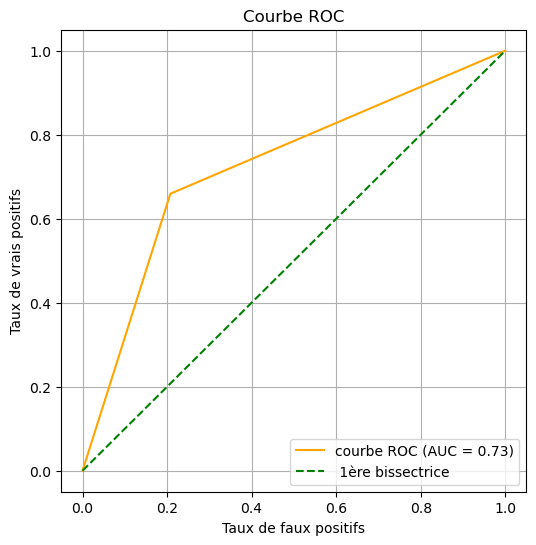

In [376]:
# Tracé de la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(faux_pos, vrai_pos, label=f"courbe ROC (AUC = {aire_auc:.2f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='green', label = " 1ère bissectrice")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1. **Courbe ROC**

La courbe ROC (*Receiver Operating Characteristic*) est une représentation graphique qui illustre les performances d’un modèle de classification binaire pour **tous les seuils possibles** de classification.

Elle trace:
- En abscisse (axe X) : le **taux de faux positifs** (*False Positive Rate*) – proportion de négatifs mal classés en positifs.
- En ordonnée (axe Y) : le **taux de vrais positifs** (*True Positive Rate*) – proportion de positifs correctement détectés (aussi appelé *Recall* ou *sensibilité*).

Chaque point de la courbe correspond à un **seuil de décision différent** appliqué aux probabilités prédites par le modèle.

Plus la courbe s'éloigne de la première bissectrice, mieux c'est. Cela traduit le fait que le modèle classifie mieux que l'aléatoire.

---

2. **AUC – Aire sous la courbe ROC**

L’AUC (*Area Under the Curve*) correspond à l’aire sous la courbe ROC. Elle résume **la capacité globale du modèle à distinguer entre les deux classes**, sans dépendre d’un seuil particulier.

- **AUC = 1** : modèle parfait (sépare parfaitement les classes)
- **AUC = 0.5** : modèle aléatoire (aucune capacité de discrimination)
- **AUC < 0.5** : modèle trompeur (classe les exemples dans le mauvais sens)

Plus l’AUC est proche de **1**, plus le modèle a une **forte capacité discriminante**.  
Elle est très utile pour comparer plusieurs modèles, même si leurs seuils de décision diffèrent.

# Détermination du **seuil** (probabilité) optimal par la **méthode de Youden**

La **méthode de Youden** est une approche permettant de déterminer le seuil optimal dans un problème de classification binaire, en maximisant conjointement la *sensibilité* et la *spécificité* du modèle.
L'indice de Youden est défini comme suit:

$$
J = \text{Sensibilité} + \text{Spécificité} - 1
$$

La formule classique de l’indice de Youden peut être reformulée en utilisant le fait que :

$$
\text{Spécificité} = 1 - \text{Taux de faux positifs} = 1 - \text{FPR}
$$

En remplaçant dans l'expression initiale, on obtient :

$$
J = \text{Sensibilité} + (1 - \text{FPR}) - 1 = \text{Sensibilité} - \text{FPR}
$$

Ainsi, maximiser l’indice de Youden revient à **minimiser les faux positifs tout en maximisant les vrais positifs**.

où:
  - **Sensibilité** (*taux de vrais positifs*) : proportion de positifs correctement identifiés.
  - **Spécificité** (*taux de vrais négatifs*) : proportion de négatifs correctement identifiés.
  - **FPR** : False Positive Rate

---

**Avantages**

  - Fournit un **seuil optimal** équilibrant la détection des vrais positifs et la limitation des faux positifs.
  - Pertinent quand le **coût des erreurs est similaire** dans les deux classes.
  - Peut s’avérer **plus performant que le seuil par défaut ($0.5$)**, notamment en cas de classes déséquilibrées.

---

#### **Exemple visuel**
Le **point le plus éloigné de la diagonale** dans la courbe ROC correspond au **seuil optimal** selon l’indice de Youden, marquant un compromis maximal entre sensibilité et spécificité.


In [377]:
faux_pos, vrai_pos, seuils = roc_curve(y_test, y_pred_new)

In [378]:
# calcul de l'indice de Youden
indice_youden = vrai_pos - faux_pos

In [379]:
# indice optimal
ind_opt = indice_youden.argmax()

In [380]:
# seuil optimal
seuil_opt = seuils[ind_opt]

In [381]:
print(f"Le seuil optimal est : {(seuil_opt*100):.1f}%")

Le seuil optimal est : 45.4%


# Prédictions avec seuil optimal & Analyse des métriques de performances

In [382]:
# Predictions en valeurs binaires
y_pred_binary = (y_pred_new >= seuil_opt).astype("int")

In [383]:
y_pred_binary

38665    0
19854    0
11809    1
24744    0
43009    0
        ..
17267    0
55404    0
32029    0
49281    1
51792    0
Length: 13641, dtype: int32

In [384]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      6907
           1       0.73      0.72      0.73      6734

    accuracy                           0.73     13641
   macro avg       0.73      0.73      0.73     13641
weighted avg       0.73      0.73      0.73     13641



## Analyse comparative des performances selon deux seuils de classification

Deux prédictions ont été effectuées à partir du même modèle, en variant uniquement le **seuil de décision** :

  - **Seuil par défaut** : $0.5$
  - **Seuil optimisé (indice de Youden)** : seuil déterminé automatiquement à partir de la courbe ROC pour maximiser $J = \text{Sensibilité} + \text{Spécificité} - 1$

---
**1. Performance globale**

  - **Accuracy** dans les deux cas : **0.73** (identique)
  - La performance globale semble stable, mais **la répartition des erreurs change selon le seuil appliqué**

---

#### **2. Comparaison des métriques par classe**

| Classe | Seuil 0.5 (défaut) | Seuil Youden | Évolution              |
|--------|--------------------|---------------|-------------------------|
| Précision 0 | 0.70           | 0.73          | +3 pts (moins de faux positifs) |
| Rappel 0    | 0.79           | 0.74          | -5 pts (perte de détection)     |
| F1-score 0  | 0.75           | 0.74          | ~équivalent                      |
| Précision 1 | 0.76           | 0.73          | -3 pts                          |
| Rappel 1    | 0.66           | 0.72          | +6 pts (meilleure détection)    |
| F1-score 1  | 0.70           | 0.73          | +3 pts (bénéfice net)           |

---

**3. Interprétation**

  - Le **seuil par défaut** ($0.5$) privilégie une **précision élevée** sur les cas positifs (classe 1), mais il **rate plus de vrais malades** (rappel = 0.66).
  - Le **seuil de Youden** offre un compromis :
    - **Rappel de la classe 1 amélioré** (0.72 contre 0.66) → meilleure capacité à détecter les malades.
    - Légère **baisse de précision**, mais **hausse du F1-score**, ce qui reflète un **meilleur équilibre global**.
    - Le **rappel de la classe 0** baisse un peu, car on classe davantage d’individus comme malades.
---
**4. Conclusion**

Le Passage d'un seui par défaut fixé à 0.5 (50%) à un seuil optimié permet:
  - De **mieux détecter les vrais positifs** (malades), ce qui est primordial dans le contexte médical
  - D'obtenir un **F1-score plus homogènes entre les deux classes**, sans perdre en **accuracy**
  - De proposer un **modèle plus équilibré** en matière d'erreurs, qui est mieux adapté à des contextes sensibles où les faux négatifs doivent être limités.
